# Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from multimode_expts.analysis_notebooks.expts_run_base import *

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [3]:
expts_base_inst = expts_run_base(data_path=r'H:\Shared drives\SLab\Multimode\experiment\250505_craqm', 
                            config_name='hardware_config_202505.yml',
                              exp_param_name='experiment_config.yml', qubit_i=0)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_craqm
Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data
Hardware configs will be read from C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\configs\experiment_config.yml
<Pyro4.core.Proxy at 0x16fc9fe9400; not connected; for PYRO:obj_5a668afe9d234dca82be2475bbf95f69@192.168.137.101:32795>
Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\bosonic', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages',

# Characterization

## Parity Delay

In [12]:
def do_parity_delay(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,
    step=0.05,
    expts=100,
    reps=200,
    rounds=1,
    qubits=[0],
    prepulse=True,
    normalize=False,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    pre_gate_sweep_pulse=[],
    man_mode_no=1,
    relax_delay=2500
):
    """Run the Parity Delay experiment with configurable parameters."""
    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'prepulse': prepulse,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'pre_sweep_pulse': [],
        'pre_gate_sweep_pulse': prep_man_pi
    }
    # print("expt_path:", expt_path)
    # print("config_path:", config_path)
    
    
    parity_delay_exp = expts_base_inst.meas.single_qubit.parity_delay.ParityDelayExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ParityDelayExperiment', config_file=config_path
    )
    parity_delay_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_delay_exp.cfg.expt = expt_cfg
    parity_delay_exp.cfg.device.readout.relax_delay = [relax_delay] 
    parity_delay_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_delay_exp


In [13]:
parity_delay_exp = do_parity_delay(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file)

  0%|          | 0/100 [00:00<?, ?it/s]

mesuring channels [5] with ADCs [0]


TypeError: acquire() got an unexpected keyword argument 'debug'

Attempted to init fitparam 2 to -500, which is out of bounds -360 to 360. Instead init to 0.0
Attempted to init fitparam 4 to -139.45127497922957, which is out of bounds -459.0473051948052 to -293.6482792207792. Instead init to -376.34779220779217
p1: 0.2944121037307816
p2: -78.84567497481153
Pi length: 1.593058701988019
Pi/2 length: 0.743908830661374
p1: 0.2914528866870536
p2: -73.97123208276513
Pi length: 1.562776234099931
Pi/2 length: 0.7050046647675725


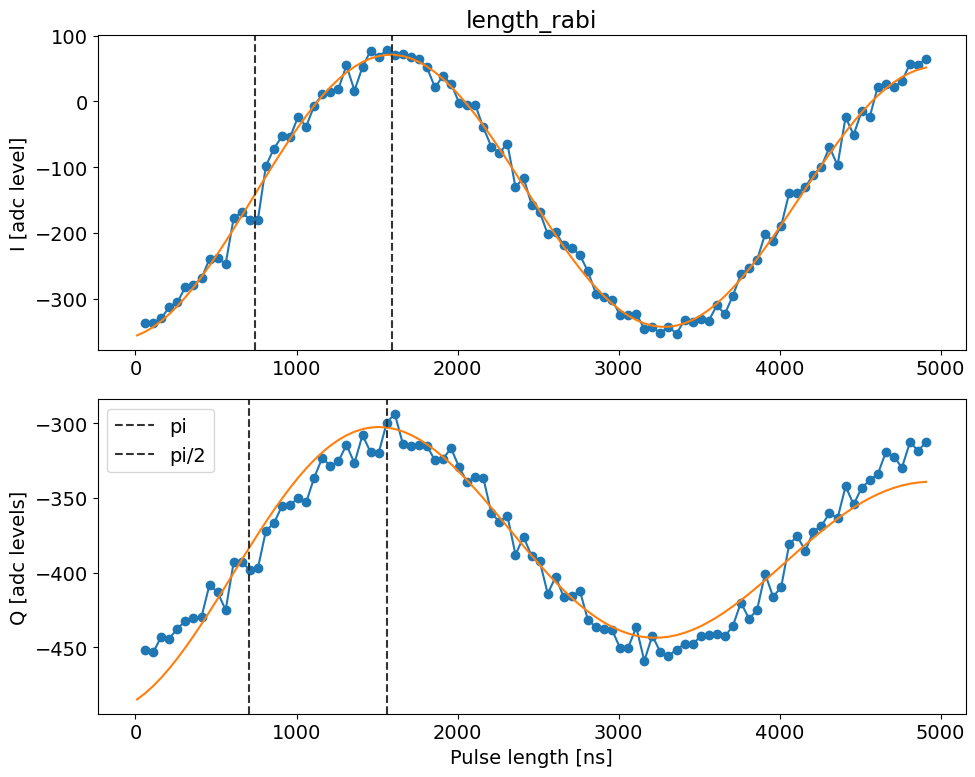

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-19_05-15-09_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-19.md


In [530]:
from multimode_expts.fit_display_classes import LengthRabiFitting
# Analyze the data
length_rabi_analysis = LengthRabiFitting(parity_delay_exp.data, config = parity_delay_exp.cfg)
length_rabi_analysis.analyze(fitparams = [500, 0.05, -500, None, None, None])
length_rabi_analysis.display(title_str='Length Rabi General F0g1')

In [ ]:
## Assign to config 
expts_base_inst.config_thisrun.device.manipulate.revival_time[0] = length_rabi_analysis.results['pi_length']

## Manipulate Parity Spectroscopy

In [14]:
def do_parity_freq_experiment(
    start=4975,
    stop=4995,
    step=0.1,
    reps=300,
    rounds=1,
    qubit=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=20,
    manipulate_no=1,
    displace=(True, 0.1, 1000),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500
):
    """
    Run the Parity Frequency Experiment with configurable parameters.
    """
    
    expt_cfg = {
        'start': start,
        'stop': stop,
        'step': step,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubit,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'span': span,
        'manipulate': manipulate_no,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse
    }
    # Example usage of relax_delay in experiment config:
    parity_freq_exp = expts_base_inst.meas.single_qubit.parity_freq.ParityFreqExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, prefix='ParityFreqExperiment', config_file=expts_base_inst.config_file
    )
    parity_freq_exp.cfg = AttrDict(deepcopy(expts_base_inst.config_thisrun))
    parity_freq_exp.cfg.expt = expt_cfg
    parity_freq_exp.cfg.device.readout.relax_delay = [relax_delay]
    parity_freq_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_freq_exp


In [18]:
parity_freq_exp = do_parity_freq_experiment()

  0%|          | 0/200 [00:00<?, ?it/s]

mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with ADCs [0]
mesuring channels [5] with A

Found peak in amps at [MHz] 4984.555164368671, HWHM 1.5444574754633906
Found peak in I at [MHz] 4984.515728266289, HWHM 1.925559975946759
Found peak in Q at [MHz] 4984.500189167099, HWHM 1.9821191325381946


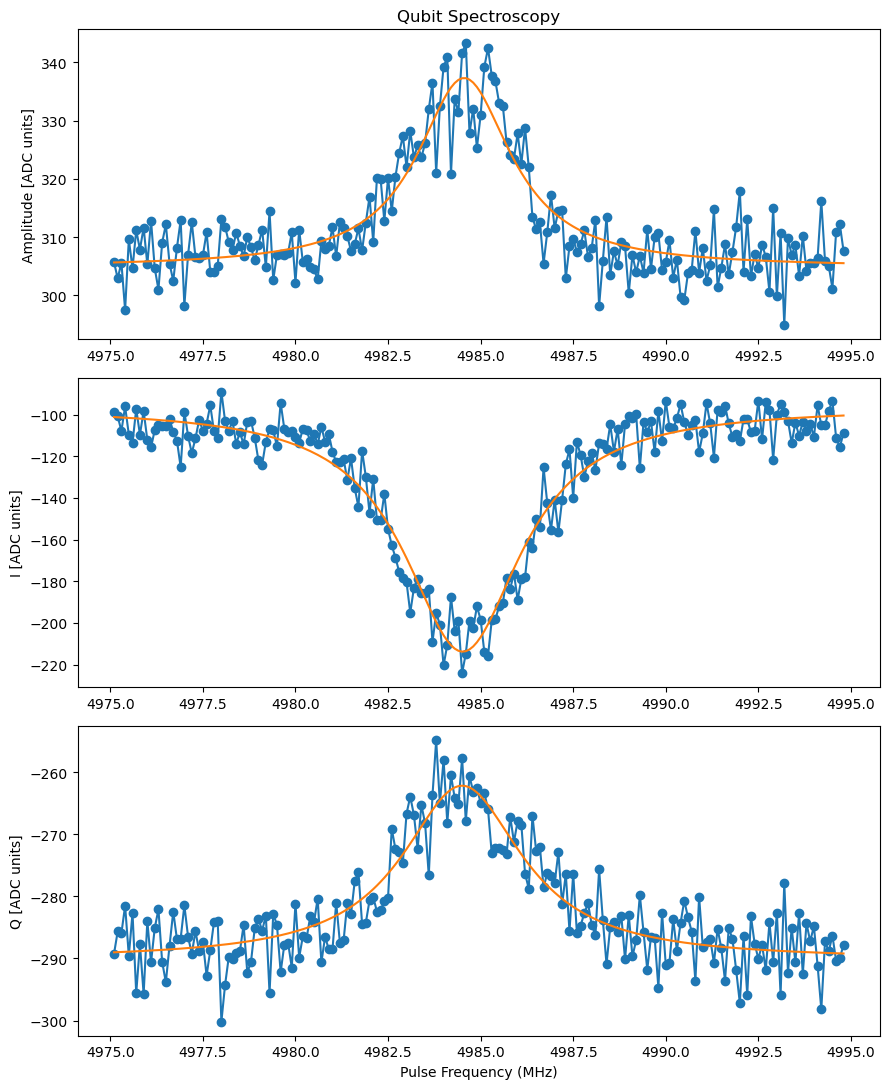

In [19]:
from fit_display_classes import Spectroscopy
spec = Spectroscopy(parity_freq_exp.data, config=parity_freq_exp.cfg)
spec.analyze()
spec.display()

In [87]:
expts_base_inst.config_thisrun.device.manipulate.f_ge[0] = spec.data['fit_avgi'][2]

## Manipulate SPectroscopy (Abandoned)

In [ ]:
##

In [5]:
def do_cavity_spectroscopy(
    config_thisrun,
    expt_path,
    config_path,
    start=4975,
    step=0.01,
    expts=2000,
    reps=100,
    pulse_e=False,
    pulse_f=False,
    cavity_name='manipulate',
    drive_gain=500,
    qubit=0,
    RF_modulation=[False, 1055, 5000, 'high'],
    relax_delay=200
):
    """Run the Cavity Spectroscopy experiment with configurable parameters."""
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'pulse_e': pulse_e,
        'pulse_f': pulse_f,
        'cavity_name': cavity_name,
        'drive_gain': drive_gain,
        'qubit': qubit,
        'RF_modulation': RF_modulation
    }
    cavity_spec_exp = expts_base_inst.meas.single_qubit.cavity_spectroscopy.CavitySpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavitySpectroscopyExperiment', config_file=config_path
    )
    cavity_spec_exp.cfg = AttrDict(deepcopy(config_thisrun))
    cavity_spec_exp.cfg.expt = expt_cfg
    cavity_spec_exp.cfg.device.readout.relax_delay = [relax_delay]
    cavity_spec_exp.go(analyze=False, display=False, progress=True, save=True)
    return cavity_spec_exp


def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.manipulate.f_ge[0] = [rspec.data['fit'][0]]
    print('Updated man_freq frequency!')

In [7]:
cav_spec = do_cavity_spectroscopy(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    start=4980,
    step=0.01,
    expts=2000,
    reps=100,
    drive_gain=500,
    pulse_e=False,
    pulse_f=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

generator 3 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 3, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 3 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 3, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 3 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 3, but it's not multiplexed and doesn't have a mixer,

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00004_CavitySpectroscopyExperiment.h5


Found peak in amps at [MHz] 4997.298904820421, HWHM 3.148540247056339
Found peak in I at [MHz] 4997.009158894696, HWHM 0.013512330957129719
Found peak in Q at [MHz] 4995.719807747144, HWHM -0.226182560741961


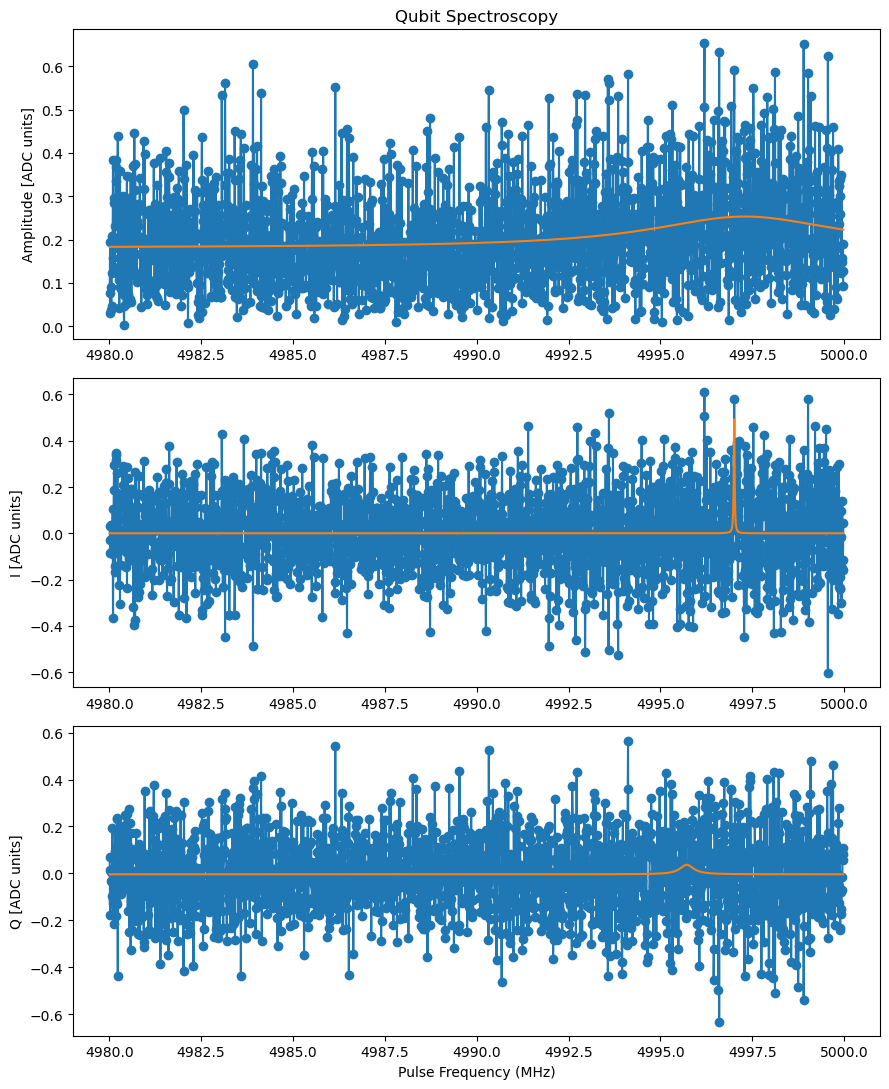

In [8]:
from fit_display_classes import Spectroscopy
spec = Spectroscopy(cav_spec.data, config=cav_spec.cfg)
spec.analyze()
spec.display()

## Manipulate Ramsey (to finetune frequency)
- This will use displace pulse instead do qubit pi/2 to calibrate; we want fine calibration of anipulate frequency not some fast way of extracting T2 time or finding stark shift on f0g1 transition
- Make sure displacements are small $(\alpha \approx 0.2)$
- Somehow i don't get full contrast, like the lowst i,q value dont correspond to g 




In [4]:
def do_cavity_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=100,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=50,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    relax_delay=2500      # relax delay
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True, config_thisrun.device.manipulate.f_ge[man_mode_no-1], 1000, 
                                config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 0,
                                  4]
    #[on/off, freq, gain, sigma (mus), phase, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = expts_base_inst.meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse # post sweep pulse
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey


In [5]:
cavity_ramsey = do_cavity_ramsey(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    man_mode_no=1, 
    ramsey_freq=0.2,
    step = 0.2, 
    expts = 100, 
    reps = 500,
    user_defined_pulse=[True,4984.520378258608 , 1000, 
                                expts_base_inst.config_thisrun.device.manipulate.displace_sigma[0],
                                  0,
                                  4])
    #user defined pulse [on/off, freq, gain, sigma (mus), phase, channel] )

phase update channel: [3]
This is designed for displacing manipulate mode, not for swapping pi/2 into man
if user length is 0, then it is a gaussian pulse with sigma 20 cycles
user length: 0
mesuring channels [5] with ADCs [0]
phase step deg: 14.4
phase step logic: +
inide t2 cavity acquire
100


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00023_CavityRamseyExperiment.h5


In [6]:
from fit_display_classes import RamseyFitting
cavity_ramsey_analysis = RamseyFitting(
        cavity_ramsey.data, config=cavity_ramsey.cfg,
    )

No echoes in the data
Attempted to init fitparam 1 to 2.2727272727272725, which is out of bounds 0.00510204081632653 to 0.7653061224489796. Instead init to 0.385204081632653
Current pi pulse frequency: 4984.520378258608
Fit frequency from I [MHz]: 0.19777712954459897 +/- 0.0006960323446439118
Suggested new pi pulse frequency from fit I [MHz]:
 	4984.522601129063
 	4984.918155388153
T2 Ramsey from fit I [us]: 110.0479720405962
Fit frequency from Q [MHz]: 0.3704480975116437 +/- 0.026875649285804933
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4984.349930161096
 	4985.09082635612
T2 Ramsey from fit Q [us]: 5.8800000000000034


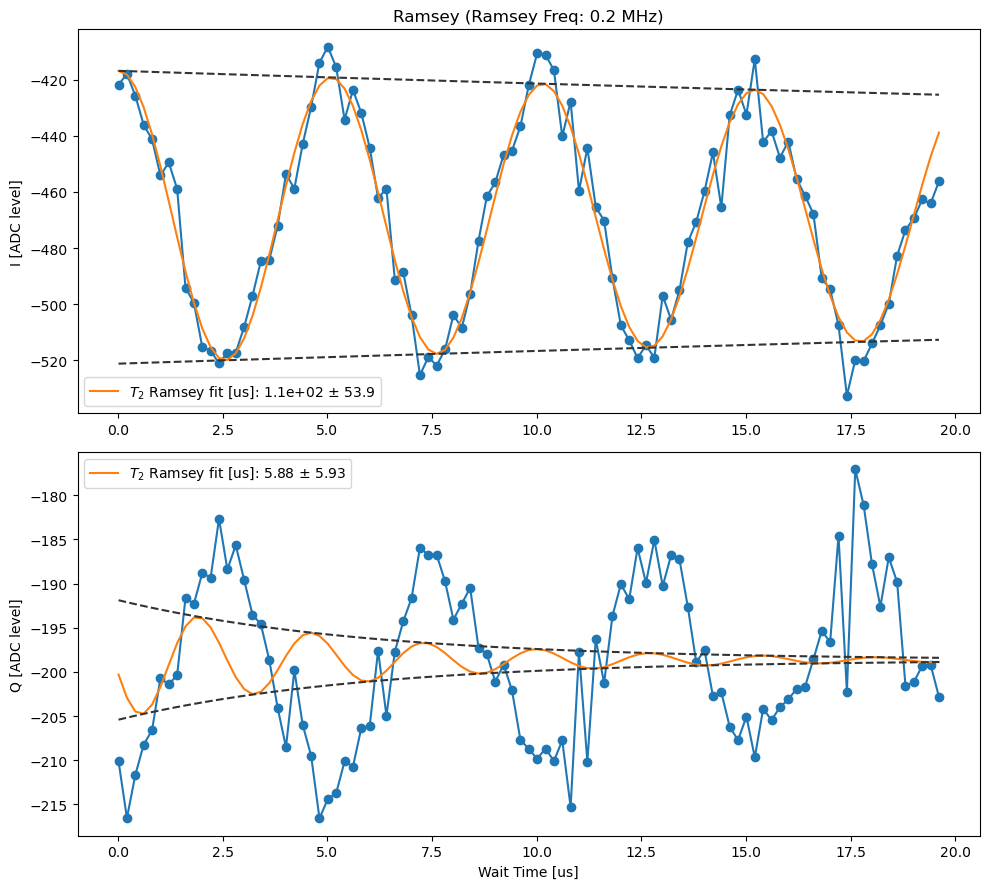

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-25_08-45-54_Cavity_Ramsey_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-25.md


In [7]:
cavity_ramsey_analysis.analyze()
cavity_ramsey_analysis.display(f_test = cavity_ramsey.cfg.expt.user_defined_pulse[1],title_str='Cavity Ramsey Analysis')

In [8]:
expts_base_inst.config_thisrun.device.manipulate.f_ge[0] = 4984.522601129063 #

## Gain to Alpha Calibration

Will do tomography on the vaccum state 

$W_{\alpha} (|0\rangle\langle0|) = \frac{2}{\pi} e^{-2|\alpha|^2}$

In [ ]:
def do_parity_gain_experiment(
    config_thisrun,
    expt_path,
    config_path,
    start=0,
    step=115,
    expts=100,
    reps=500,
    rounds=1,
    qubit=0,
    qubits=[0],
    normalize=False,
    single_shot=True,
    singleshot_reps=10000,
    singleshot_active_reset=False,
    singleshot_man_reset=True,
    singleshot_storage_reset=True,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    span=1000,
    prep_e=False,
    manipulate=1,
    displace=(True, 0.05),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500
):
    """
    Run the Parity Gain Experiment with configurable parameters.
    """
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubit': qubit,
        'qubits': qubits,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'singleshot_active_reset': singleshot_active_reset,
        'singleshot_man_reset': singleshot_man_reset,
        'singleshot_storage_reset': singleshot_storage_reset,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'span': span,
        'prep_e': prep_e,
        'manipulate': manipulate,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else []
    }
    parity_gain_exp = expts_base_inst.meas.single_qubit.parity_gain.ParityGainExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ParityGainExperiment', config_file=config_path
    )
    parity_gain_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_gain_exp.cfg.expt = expt_cfg
    parity_gain_exp.cfg.device.readout.relax_delay = [relax_delay]
    parity_gain_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_gain_exp

In [10]:
prep_man_pi

NameError: name 'prep_man_pi' is not defined

In [ ]:
parity_gain_expt = do_parity_gain_experiment(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file
)

sscfg active reset False
mesuring channels [5] with ADCs [0]


  0%|          | 0/10000 [00:00<?, ?it/s]

mesuring channels [5] with ADCs [0]


  0%|          | 0/10000 [00:00<?, ?it/s]

[3]
1
mesuring channels [5] with ADCs [0]


  0%|          | 0/20000 [00:00<?, ?it/s]

Rotating data by -0.4802685316270964 radians
(500, 100)


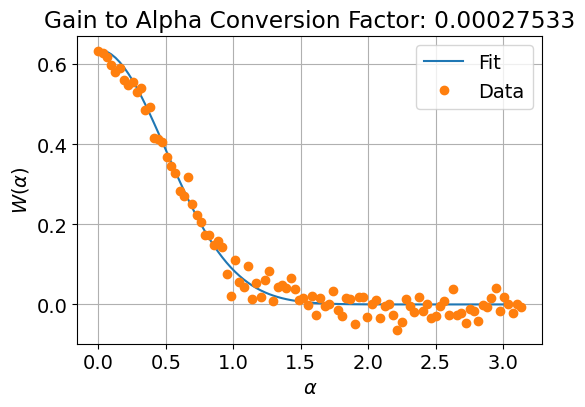

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-19_05-25-05_Gain_to_Alpha_Conversion_Factor_0.00027533.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-19.md
alpha = 1 requires gain of : 3631.96689729


In [545]:
from fitting_folder.wigner import WignerAnalysis
wigner_analysis = WignerAnalysis(parity_gain_expt.data, config=parity_gain_expt.cfg)
gain_to_alpha, result, ydata = wigner_analysis.get_gain_to_alpha()

In [546]:
1/0.00027

3703.7037037037035

In [370]:
expts_base_inst.config_thisrun.device.manipulate.gain_to_alpha[0]

0.00014281

In [547]:
expts_base_inst.config_thisrun.device.manipulate.gain_to_alpha[0] = gain_to_alpha

## Photon Number Resolved  Spectroscopy

In [249]:
def do_pulse_probe(
    config_thisrun, 
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=400,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
    ): 
    qspec = expts_base_inst.meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, prefix='PulseProbeSpectroscopyExperiment', 
        config_file=expts_base_inst.config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        qubits = [0],
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        sigma=sigma,
        qubit=qubit,
        prepulse = prepulse, 
        pre_sweep_pulse = pre_sweep_pulse,
        gate_based = gate_based,
    )

    qspec.cfg.device.readout.relax_delay = [relax_delay] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

qubit register page: 1, frequency register: 21


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00089_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3567.3459773374816, HWHM -0.05979923740774963
Found peak in I at [MHz] 3567.3439966605147, HWHM -0.05454388093036626
Found peak in Q at [MHz] 3566.843780950836, HWHM 106.85806328384594


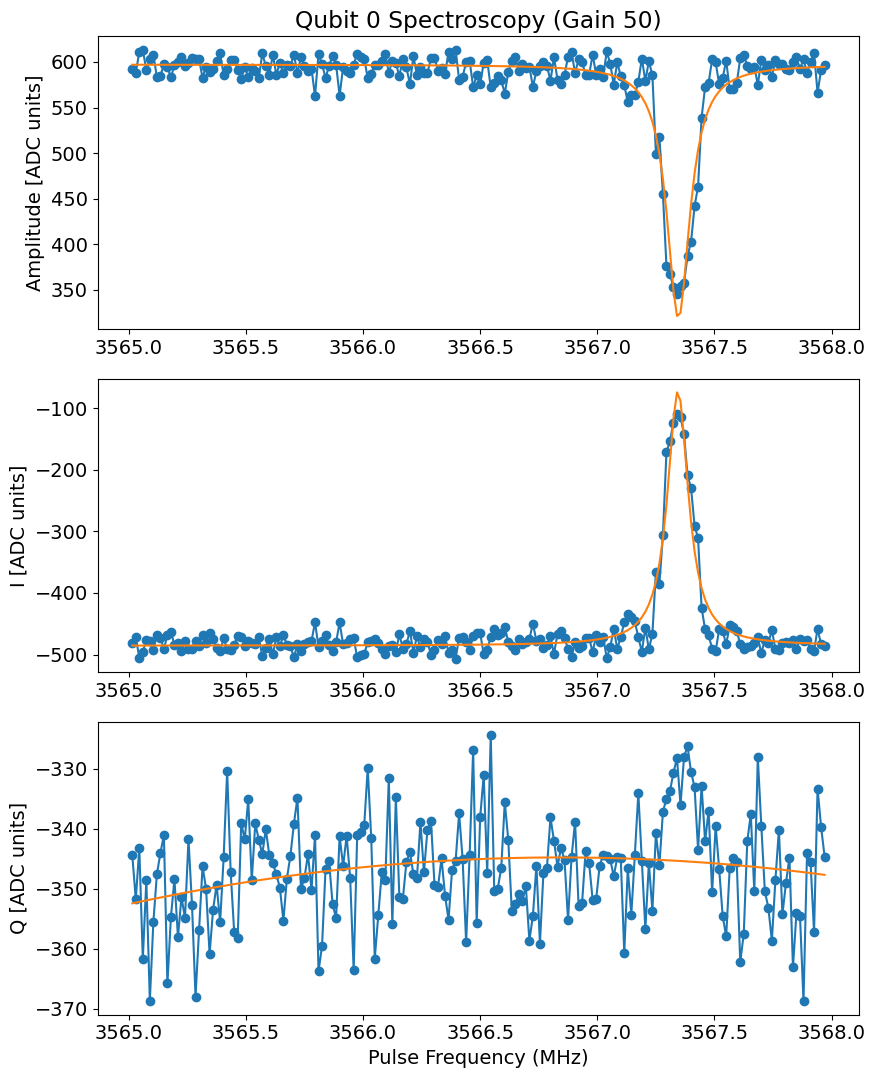

In [258]:
qspec = do_pulse_probe(
    config_thisrun=expts_base_inst.config_thisrun,
    start=3565,  # [MHz]
    step=0.015,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=50,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=6.3,  # Qubit probe constant pulse length [us]
    gain=50,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=2500  # Wait time between experiments [us]
)

In [257]:
print(qspec.prog)


// Program

        regwi 3, $11, 467365305;                //freq = 467365305
        regwi 3, $12, 405728358;                //phase = 405728358
        regwi 3, $14, 800;                      //gain = 800
        regwi 3, $15, 590469;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 645 
        synci 86;
        regwi 2, $4, 599066256;                 //
        bitwi 2, $4, $4 << 2;
        mathi 2, $4, $4 + 2;
        synci 200;
        regwi 0, $13, 0;
        regwi 0, $14, 199;
LOOP_I: regwi 0, $15, 49;
LOOP_J: regwi 1, $21, 599066256;                //freq = 2396265026
        bitwi 1, $21, $21 << 2;
        mathi 1, $21, $21 + 2;
        regwi 1, $22, 0;                        //phase = 0
        regwi 1, $24, 50;                       //gain = 50
        regwi 1, $23, 224;                      //addr = 224
        regwi 1, $27, 304;                      //addr2 = 304
        regwi 1, $28, 25;                       //gain2 = 25
        regwi 1, $29, 

#### Man |1>

In [278]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun )
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)

In [279]:
prep_man_pi

[['qubit', 'ge', 'pi', 0], ['qubit', 'ef', 'pi', 0], ['man', 'M1', 'pi', 0]]

qubit register page: 1, frequency register: 21


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00093_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3567.048794828799, HWHM -0.05424176313303839
Found peak in I at [MHz] 3567.0498807402982, HWHM -0.04881838182745145
Found peak in Q at [MHz] 3567.969850496194, HWHM 0.0001763464122398145


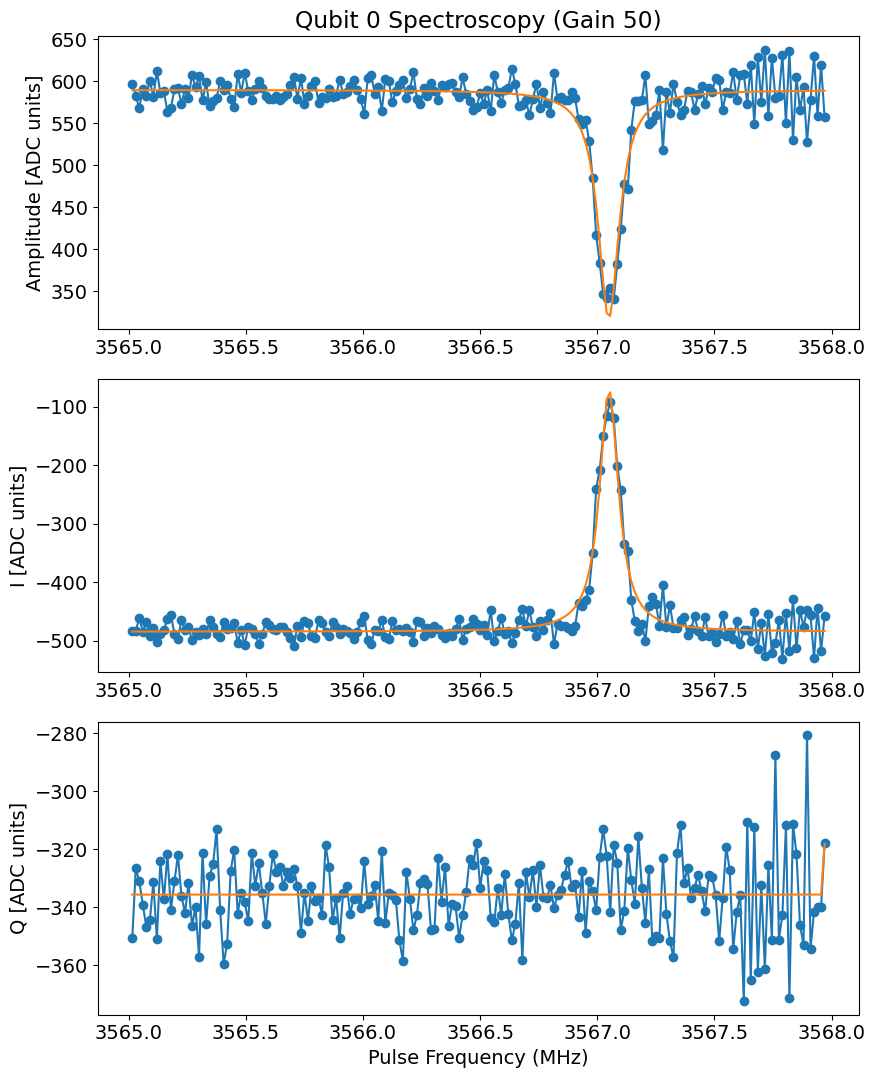

In [280]:
qspec1= do_pulse_probe(
    config_thisrun=expts_base_inst.config_thisrun,
    start=3565,  # [MHz]
    step=0.015,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=50,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=6.3,  # Qubit probe constant pulse length [us]
    gain=50,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=True,
    pre_sweep_pulse=prep_man_pi,
    gate_based=True,
    relax_delay=2500  # Wait time between experiments [us]
)

#### Man |2>

In [ ]:
##
##

In [336]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun )
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['multiphoton', 'g1-e1', 'pi', 0])
prep_man_pi.append(['multiphoton', 'e1-f1', 'pi', 0])  
# prep_man_pi = [['qubit', 'ge', 'pi', 0], 
#                ['qubit', 'ef', 'pi', 0], 
#                ]  # This is the prepulse for the manipulate mode
prep_man_pi.append(['multiphoton', 'f1-g2', 'pi', 0])  
# prep_man_pi.append(['qubit', 'ef', 'pi', 0])
# prep_man_pi.append(['man', 'M1', 'pi', 0])  # This is the prepulse for the manipulate mode
## convert it to low level pulse 
yoyoyoyo =  [['multiphoton', 'g0-e0', 'hpi', 0],
                    ['qubit'
                    '', 'ge', 'parity_M' + str(1), 0],
                    ['multiphoton', 'g0-e0', 'hpi', 180]]
pulse = mm_base_dummy.get_prepulse_creator(yoyoyoyo).pulse.tolist()
pulse

[[3567.348089, 3567.346827832447, 3567.348089],
 [9906, 0, 9906],
 [0, 1.5972763957631686, 0],
 [0, 0, 180],
 [2, 2, 2],
 ['gauss', 'const', 'gauss'],
 [0.02, 0.0, 0.02]]

In [328]:
mm_base.get_parity_str(1, True, 180, True)

[[3567.348089, 3567.346827832447, 3567.348089],
 [9906, 0, 9906],
 [0, 1.5972763957631686, 0],
 [0, 0, 180],
 [2, 2, 2],
 ['gauss', 'const', 'gauss'],
 [0.02, 0.0, 0.02]]

In [452]:
qspec2= do_pulse_probe(
    config_thisrun=expts_base_inst.config_thisrun,
    start=3565,  # [MHz]
    step=0.015,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=50,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=6.3,  # Qubit probe constant pulse length [us]
    gain=50,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based=False,
    relax_delay=8000  # Wait time between experiments [us]
)

qubit register page: 1, frequency register: 21


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Man |2> with 2 swaps with storage

In [453]:
# adding g1-e1 and e1-f1 to the prepulse 
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['multiphoton', 'g1-e1', 'pi', 0])
prep_man_pi.append(['multiphoton', 'e1-f1', 'pi', 0])  

prep_man_pi.append(['multiphoton', 'f1-g2', 'pi', 0])   # This is the prepulse for the manipulate mode
prep_man_pi.append(['storage', 'M1-S1', 'pi', 0]) 
prep_man_pi.append(['storage', 'M1-S1', 'pi', 0]) 
## convert it to low level pulse 
pulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()


# post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
# post_pulse
pulse

[[3567.346827832447,
  3423.9868279076563,
  2005.9,
  3567.055708,
  3423.724467,
  2005.32,
  348.9178150893526,
  348.9178150893526],
 [10409, 8221, 15000, 10167, 8276, 15000, 3000, 3000],
 [0.0,
  0.0,
  1.082052141523385,
  0,
  0,
  0.762198579,
  0.9561816662492874,
  0.9561816662492874],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 0, 2, 2, 0, 1, 1],
 ['g', 'g', 'flat_top', 'gauss', 'gauss', 'flat_top', 'flat_top', 'flat_top'],
 [0.035, 0.035, 0.005, 0.035, 0.035, 0.005, 0.005, 0.005]]

qubit register page: 1, frequency register: 21


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00102_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3566.761982159376, HWHM -0.05281297283543981
Found peak in I at [MHz] 3566.7643750430457, HWHM -0.04939105290922845
Found peak in Q at [MHz] 3565.59290801568, HWHM -0.0007743223055383662


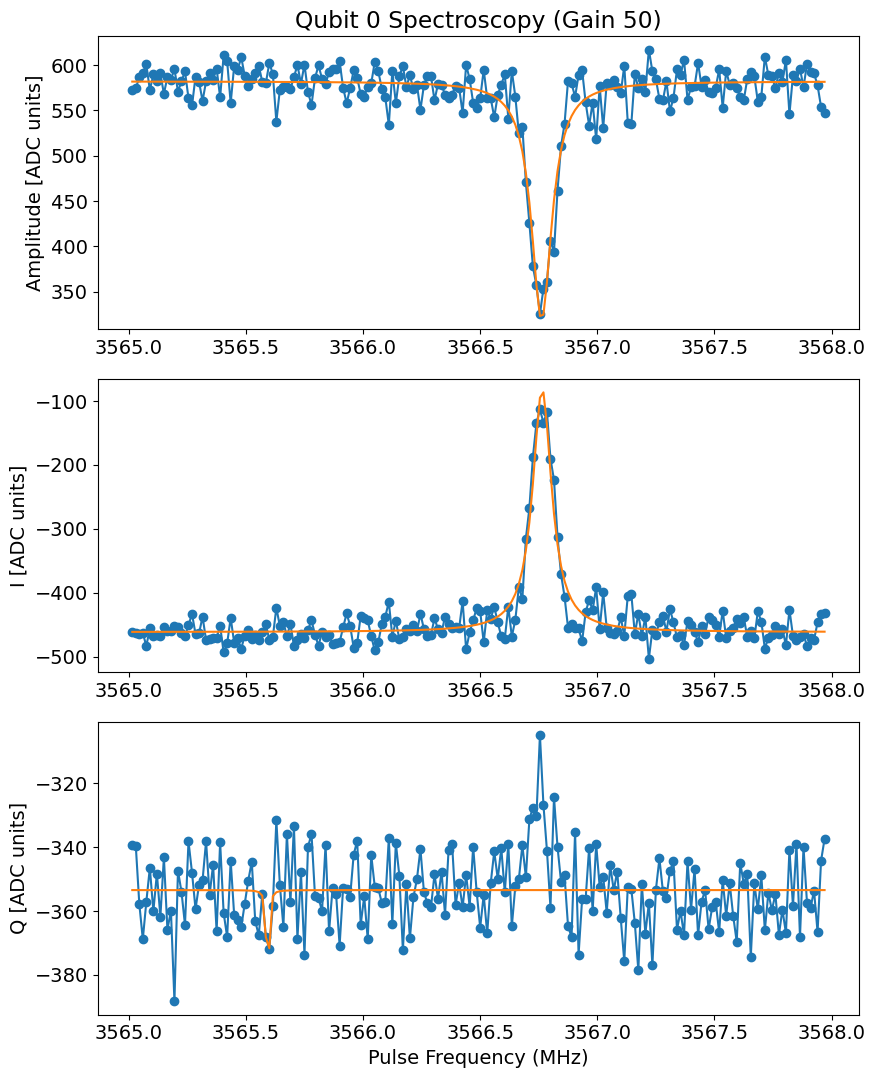

In [455]:
qspec2= do_pulse_probe(
    config_thisrun=expts_base_inst.config_thisrun,
    start=3565,  # [MHz]
    step=0.015,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=50,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=6.3,  # Qubit probe constant pulse length [us]
    gain=50,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based=False,
    relax_delay=8000  # Wait time between experiments [us]
)

In [456]:
pulse

[[3567.346827832447,
  3423.9868279076563,
  2005.9,
  3567.055708,
  3423.724467,
  2005.32,
  348.9178150893526,
  348.9178150893526],
 [10409, 8221, 15000, 10167, 8276, 15000, 3000, 3000],
 [0.0,
  0.0,
  1.082052141523385,
  0,
  0,
  0.762198579,
  0.9561816662492874,
  0.9561816662492874],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 0, 2, 2, 0, 1, 1],
 ['g', 'g', 'flat_top', 'gauss', 'gauss', 'flat_top', 'flat_top', 'flat_top'],
 [0.035, 0.035, 0.005, 0.035, 0.035, 0.005, 0.005, 0.005]]

### Man 0 + 2

In [643]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_02_pulse = []
prep_02_pulse.append(['qubit', 'ge', 'hpi', 0]) # g0 + e0 
prep_02_pulse.append(['qubit', 'ef', 'pi', 0]) # g0 + f0 
# prep_02_pulse.append(['qubit', 'ge', 'pi', 0])# e0 + f0
prep_02_pulse.append(['multiphoton', 'f0-g1', 'pi', 0]) # e0 + g1 
# prep_02_pulse.append(['multiphoton', 'g0-e0', 'pi', 0]) # g0 + e1
# prep_02_pulse.append(['multiphoton', 'e1-f1', 'pi', 0]) # g0 + f1 
# prep_02_pulse.append(['multiphoton', 'f1-g2', 'pi', 0]) # g0 + g2
prep_02_pulse
pulse = mm_base_dummy.get_prepulse_creator(prep_02_pulse).pulse.tolist()
pulse

[[3567.346809921427, 3423.9866806417763, 2005.9],
 [4636, 8221, 15000],
 [0.0, 0.0, 1.082052142],
 [0, 0, 0],
 [2, 2, 0],
 ['g', 'g', 'flat_top'],
 [0.035, 0.035, 0.005]]

qubit register page: 1, frequency register: 21


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00103_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3567.341677677792, HWHM 0.06263446420758201
Found peak in I at [MHz] 3567.3427472197836, HWHM 0.05701341079746395
Found peak in Q at [MHz] 3565.77047489256, HWHM -0.02946348915309222


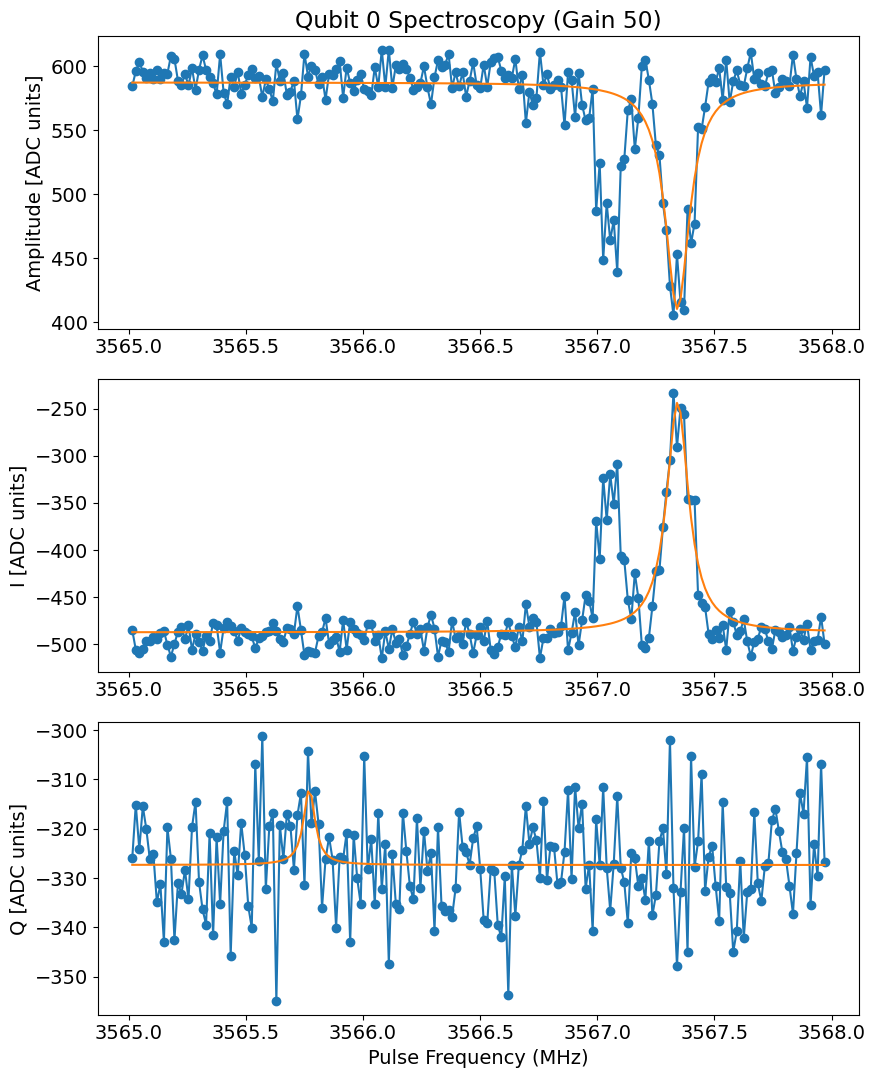

In [644]:
qspec2= do_pulse_probe(
    config_thisrun=expts_base_inst.config_thisrun,
    start=3565,  # [MHz]
    step=0.015,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=50,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=6.3,  # Qubit probe constant pulse length [us]
    gain=50,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based=False,
    relax_delay=2500  # Wait time between experiments [us]
)

# Wigner Tomography

## Generate Optimal Displacements 

In [162]:
expts_base_inst.path

'H:\\Shared drives\\SLab\\Multimode\\experiment\\250505_craqm'

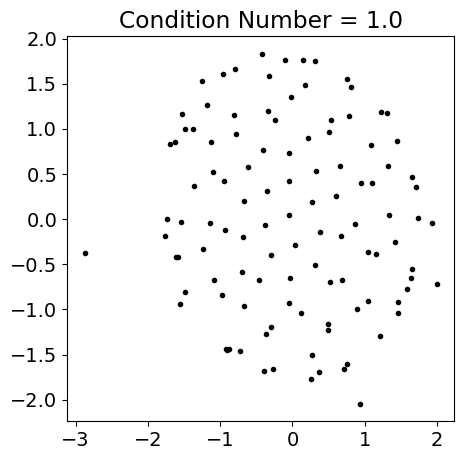

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Displacements saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\optimized_displacements_6.npy


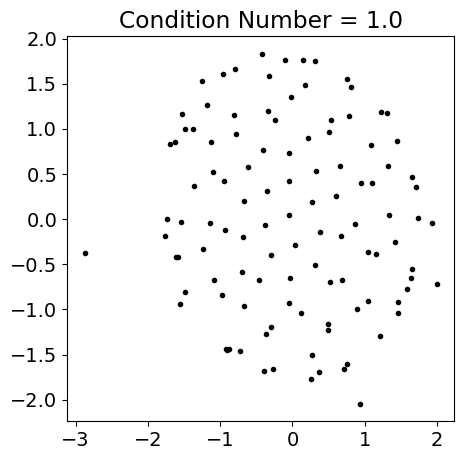

In [573]:
from fitting_folder.wigner import OptimalDisplacementGeneration
# Number of photons 
n_photon = 5
opt_alphas = OptimalDisplacementGeneration(FD = n_photon)
return_dict = opt_alphas.optimize(save_dir = expts_base_inst.expt_path )


## Wigner Tomography of |1>

In [267]:
def do_wigner_tomography_1mode(
    config_thisrun,
    expt_path,
    config_path,
    displace_length=0.05,
    displacement_path=None,
    prepulse=False,
    pre_sweep_pulse=None,
    pre_gate_sweep_pulse=None,
    reps = 1000,
    qubits=[0],
    relax_delay=2500
):
    """
    Run the Wigner Tomography 1 Mode Experiment with configurable parameters.
    """
    expt_cfg = {
        'displace_length': displace_length,
        'displacement_path': displacement_path,
        'reps': reps,
        'rounds': 1,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
        'qubits': qubits
    }
    wigner_exp = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.WignerTomography1ModeExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='WignerTomography1ModeExperiment', config_file=config_path
    )
    wigner_exp.cfg = AttrDict(deepcopy(config_thisrun))
    wigner_exp.cfg.expt = expt_cfg
    wigner_exp.cfg.device.readout.relax_delay = [relax_delay]
    wigner_exp.go(analyze=False, display=False, progress=True, save=True)
    return wigner_exp


In [266]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(1)


In [ ]:
wigner_exp = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=None,
    pre_gate_sweep_pulse = prep_man_pi
)

man mode no: 1


  0%|          | 0/133 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00002_WignerTomography1ModeExperiment.h5


In [269]:

wigner_exp.data['idata'] = wigner_exp.data['i0'] # reorder  from (expt, round, rep) to (round, rep, expt)
wigner_exp.data['qdata'] = wigner_exp.data['q0'] # reorder  from (expt, round, rep) to (round, rep, expt)
# wigner_exp.cfg.expt['rounds'] = 1
# wigner_exp.cfg.expt['expts'] = len(wigner_exp.data['alpha'])

In [249]:
wigner_exp.data['idata'].shape

(133, 1, 1000)

In [171]:
temp_data, attrs, fname = expts_base_inst.prev_data('00002_WignerTomography1ModeExperiment.h5')

In [176]:
from fitting_folder.wigner import WignerAnalysis
from slab import AttrDict
wigner_analysis = WignerAnalysis(AttrDict(temp_data), config=AttrDict(attrs['config']), mode_state_num=5, alphas = temp_data['alpha'])
initial_state = fock(wigner_analysis.m, 1)  # Initial state |0>
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

(1000, 133)


MLE Fidelity:  0.8955249001759994
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.8955')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-17_10-02-18_MLE.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-17.md


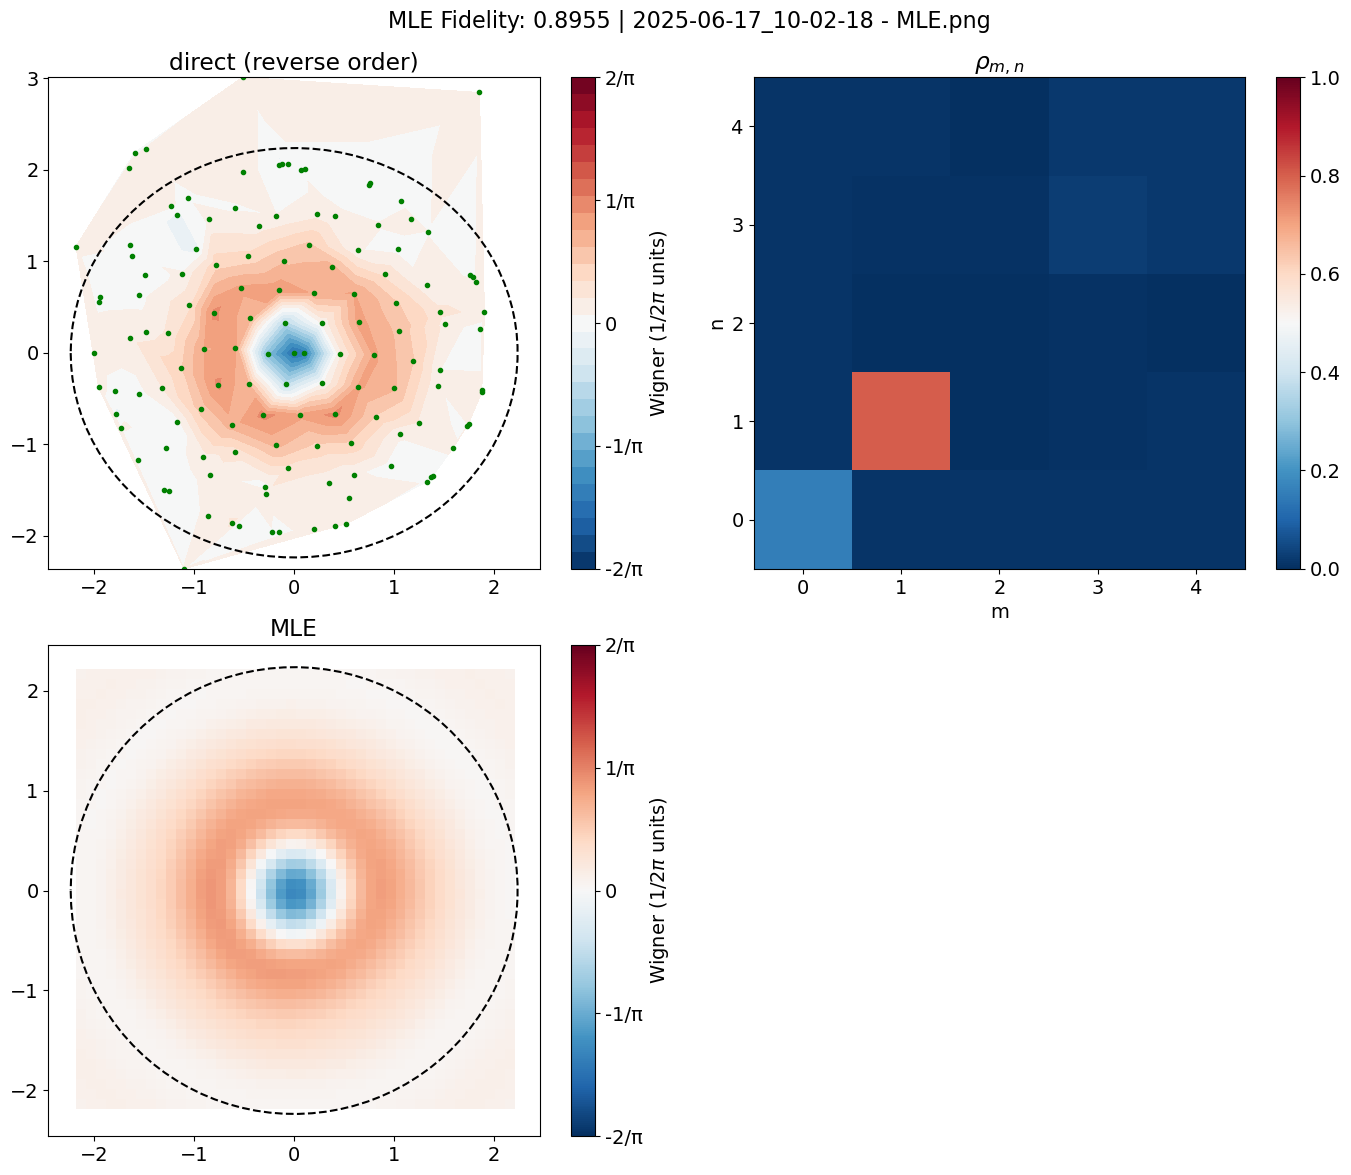

In [177]:
results = wigner_analysis.wigner_analysis_results((p_g, initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results)

In [232]:
from qutip import *

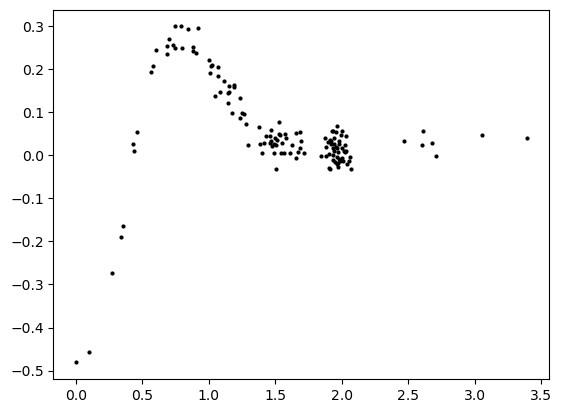

In [280]:
plt.plot(np.abs(wigner_analysis.data['alpha']), 2/np.pi *((1-allocated_counts) - allocated_counts), 'o', markersize=2, color='black')

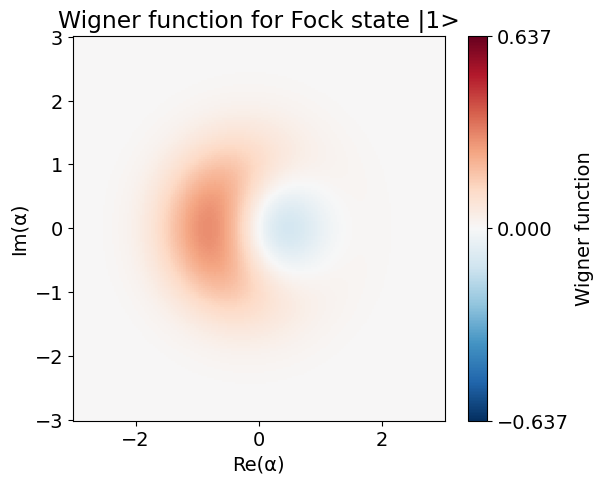

In [441]:
from qutip import wigner, fock, displace
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter

import matplotlib.pyplot as plt




# Define parameters
N = 15  # Hilbert space dimension
n = 1 # Fock state |n>
xvec = np.linspace(-3, 3, 200)
yvec = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(xvec, yvec)
alpha = X + 1j * Y

# Create Fock state
psi = (fock(N, n) - fock(N, 0)).unit()

# Compute Wigner function
W = wigner(psi, xvec, yvec)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(X, Y, W, cmap='RdBu_r', shading='auto', vmin=-2/np.pi, vmax=2/np.pi)
ax.set_xlabel('Re(α)')
ax.set_ylabel('Im(α)')
ax.set_title(f'Wigner function for Fock state |{n}>')
cb = fig.colorbar(c, ax=ax)
cb.set_label('Wigner function')
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
plt.show()

## Wigner Tomography of |2>

In [556]:
def do_wigner_tomography_1mode(
    config_thisrun,
    expt_path,
    config_path,
    displace_length=0.05,
    displacement_path=None,
    prepulse=False,
    pre_sweep_pulse=None,
    pre_gate_sweep_pulse=None,
    reps = 1000,
    qubits=[0],
    relax_delay=2500,
    gate_based = False
):
    """
    Run the Wigner Tomography 1 Mode Experiment with configurable parameters.
    """
    expt_cfg = {
        'displace_length': displace_length,
        'displacement_path': displacement_path,
        'reps': reps,
        'rounds': 1,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
        'qubits': qubits,
        'gate_based': gate_based
    }
    wigner_exp = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.WignerTomography1ModeExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='WignerTomography1ModeExperiment', config_file=config_path
    )
    wigner_exp.cfg = AttrDict(deepcopy(config_thisrun))
    wigner_exp.cfg.expt = expt_cfg
    wigner_exp.cfg.device.readout.relax_delay = [relax_delay]
    wigner_exp.go(analyze=False, display=False, progress=True, save=True)
    return wigner_exp


In [557]:
# adding g1-e1 and e1-f1 to the prepulse 
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['multiphoton', 'g1-e1', 'pi', 0])
prep_man_pi.append(['multiphoton', 'e1-f1', 'pi', 0])  

prep_man_pi.append(['multiphoton', 'f1-g2', 'pi', 0])   # This is the prepulse for the manipulate mode
## convert it to low level pulse 
pulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()


# post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
# post_pulse
pulse

[[3567.346809921427,
  3423.9866806417763,
  2005.9,
  3567.055708,
  3423.724467,
  2005.32],
 [10409, 8221, 15000, 10167, 8276, 15000],
 [0.0, 0.0, 1.082052141523385, 0, 0, 0.762198579],
 [0, 0, 0, 0, 0, 0],
 [2, 2, 0, 2, 2, 0],
 ['g', 'g', 'flat_top', 'gauss', 'gauss', 'flat_top'],
 [0.035, 0.035, 0.005, 0.035, 0.035, 0.005]]

In [563]:
wigner_exp = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based = False,
    reps = 1000
    # pre_gate_sweep_pulse = prep_man_pi
)

man mode no: 1


  0%|          | 0/261 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00014_WignerTomography1ModeExperiment.h5


In [564]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
wigner_analysis = WignerAnalysis(wigner_exp.data, config=wigner_exp.cfg, mode_state_num=10, alphas = wigner_exp.data['alpha'])
initial_state = fock(wigner_analysis.m, 2)  # Initial state |0>
allocated_counts = wigner_analysis.bin_ss_data()

(1000, 261)


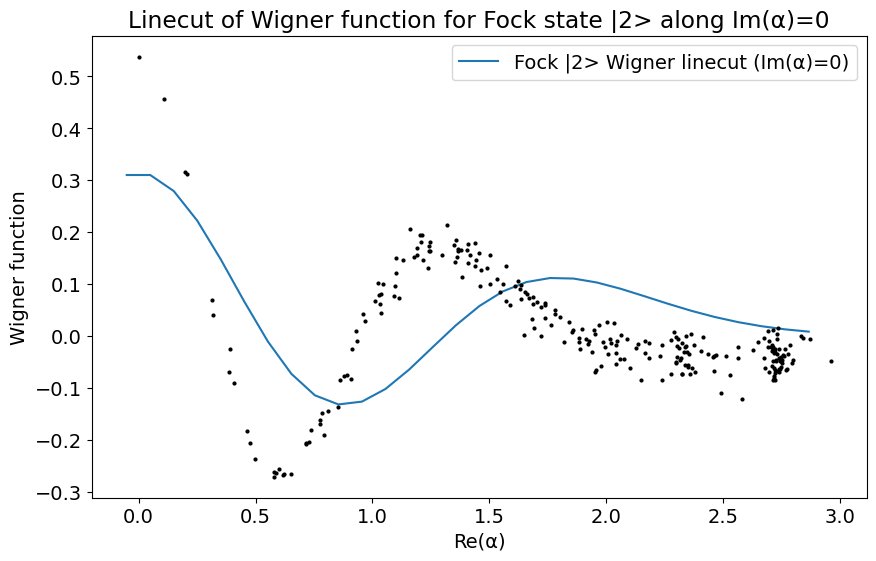

In [565]:
from qutip import wigner, fock




# Take a line cut of the Wigner function for Fock state |2> along the real axis (Im(α)=0)
N = 15  # Hilbert space dimension

# Take a line cut of the Wigner function for Fock state |2> along the real axis (Im(α)=0)

n = 2   # Fock state |2>
psi_fock2 = fock(N, n)
xvec = np.linspace(-10, 10, 200)
yvec = np.linspace(-10, 10, 200)
W_fock2 = wigner(psi_fock2, xvec, yvec)
# take linecut along the real axis (Im(α)=0) and plot 
# Find the index where Im(α)=0 (i.e., yvec closest to 0)
idx_y0 = (np.abs(yvec - 0)).argmin()
linecut = W_fock2[:, idx_y0]

idx_min = (np.abs(xvec - 0)).argmin()
idx_max = (np.abs(xvec - 3)).argmin()



plt.figure()
plt.plot(xvec[idx_min:idx_max], linecut[idx_min:idx_max], label='Fock |2> Wigner linecut (Im(α)=0)')
plt.plot(np.abs(wigner_exp.data['alpha']), 2/np.pi * (((1-allocated_counts) -allocated_counts)), 'o', markersize=2, color='black')
plt.xlabel('Re(α)')
plt.ylabel('Wigner function')
plt.title('Linecut of Wigner function for Fock state |2> along Im(α)=0')
plt.legend()
plt.show()

In [566]:
expts_base_inst.config_thisrun.device.manipulate.gain_to_alpha

[0.0002753329059097354, 0.00020045]

MLE Fidelity:  0.9335154074234077
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.9335')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-19_05-51-42_Wigner_Reconstruction_Results.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-19.md


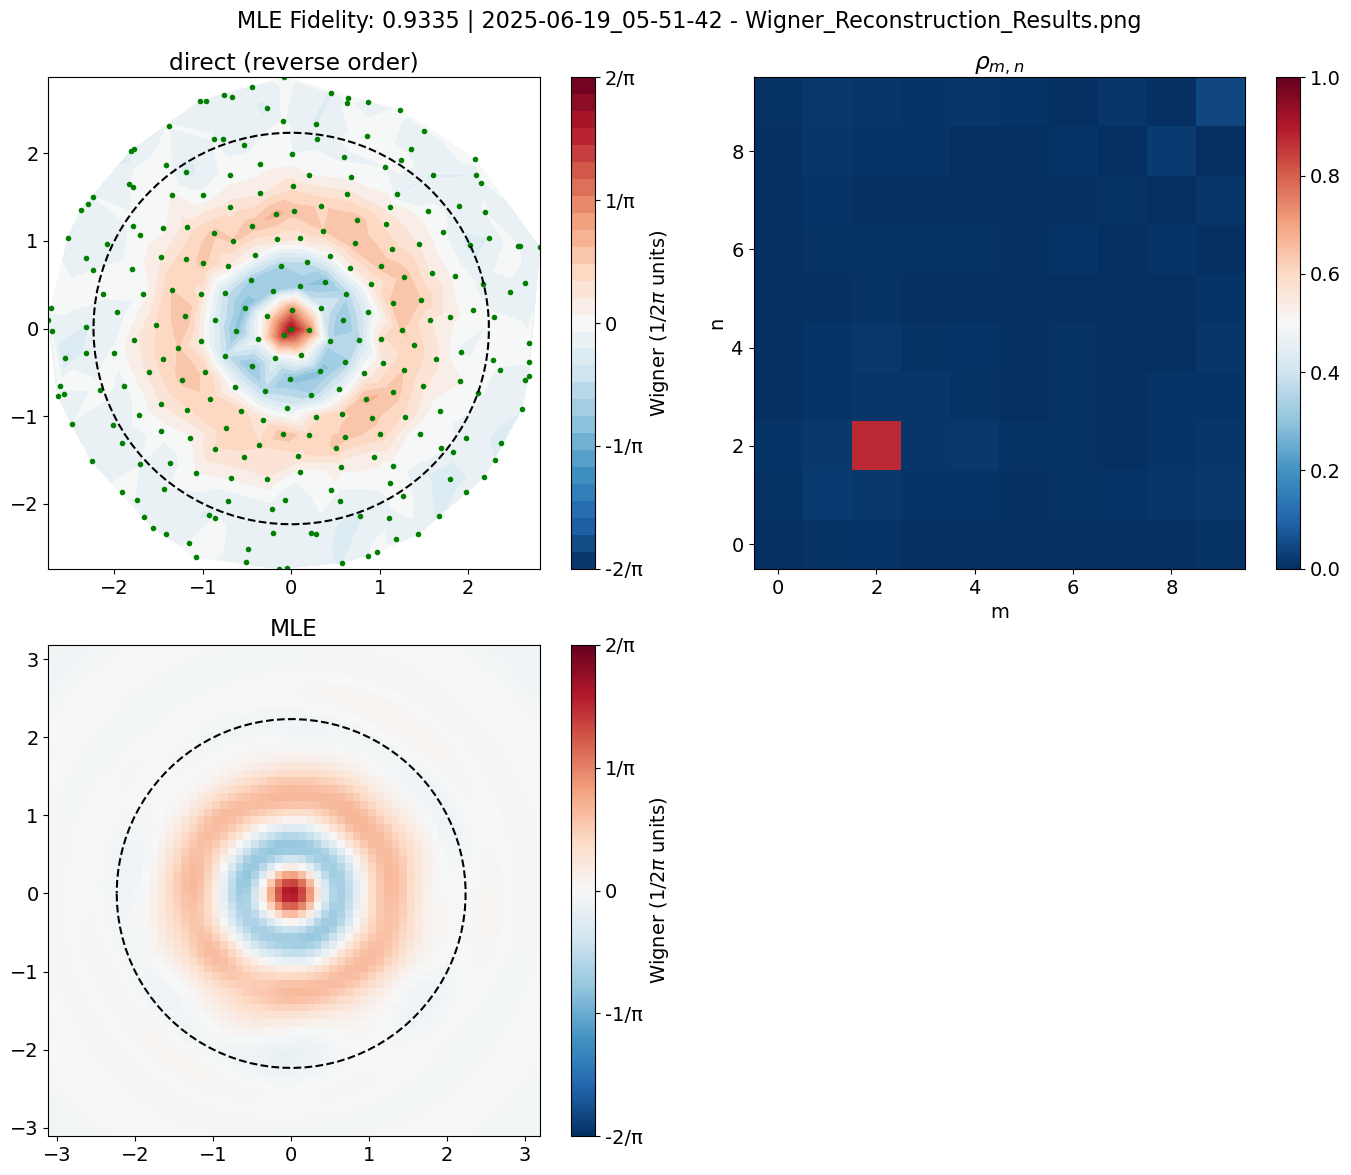

In [567]:
results = wigner_analysis.wigner_analysis_results(((1-allocated_counts) -allocated_counts), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results)

## Wigner tOMOGRAPHY OF |ALPHA = 0.5>

In [595]:

cfg = expts_base_inst.config_thisrun
pulse = [[cfg.device.manipulate.f_ge[0]], 
         [int(1/cfg.device.manipulate.gain_to_alpha[0])], 
         [0], 
         [270],
           [4],
             ['g'],
               [cfg.device.manipulate.displace_sigma[0]]]
pulse


[[4984.520131335452], [3631], [0], [270], [4], ['g'], [0.05]]

In [596]:
wigner_exp_alpha_half_swap = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 200,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based = False,
    relax_delay=2500
)

man mode no: 1


  0%|          | 0/111 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00017_WignerTomography1ModeExperiment.h5


(200, 111)


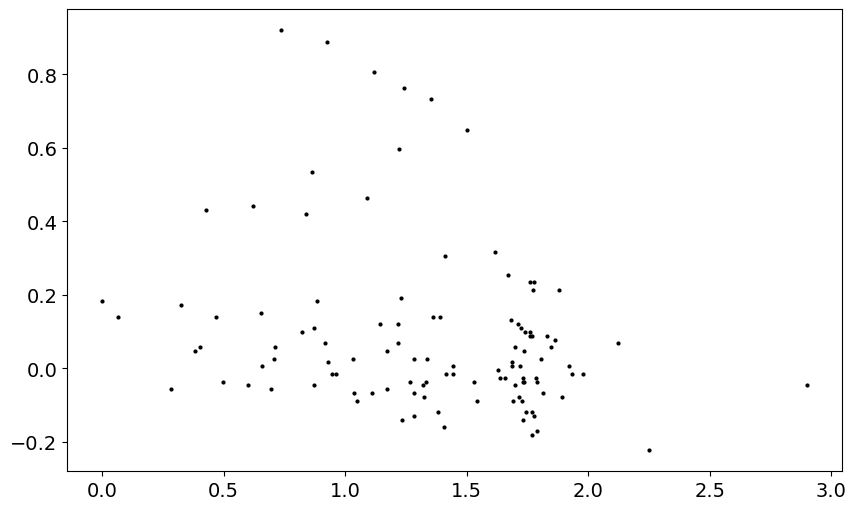

In [597]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock, coherent
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_alpha_half_swap.data, config=wigner_exp_alpha_half_swap.cfg, mode_state_num=4, 
                                 alphas = wigner_exp_alpha_half_swap.data['alpha'])
initial_state = (coherent(wigner_analysis.m, alpha =1*np.exp(-1.0j*np.pi/2)) ).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g
plt.plot(np.abs(wigner_exp_alpha_half_swap.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

In [598]:
print(coherent(wigner_analysis.m, alpha =0.5) )

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.88249471]
 [0.44128304]
 [0.1556681 ]
 [0.04732666]]


In [599]:
print(fock(wigner_analysis.m, 1) ) # Initial state |0>

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]


MLE Fidelity:  0.13618776777097033
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.1362')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-19_09-14-42_alpha.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-19.md


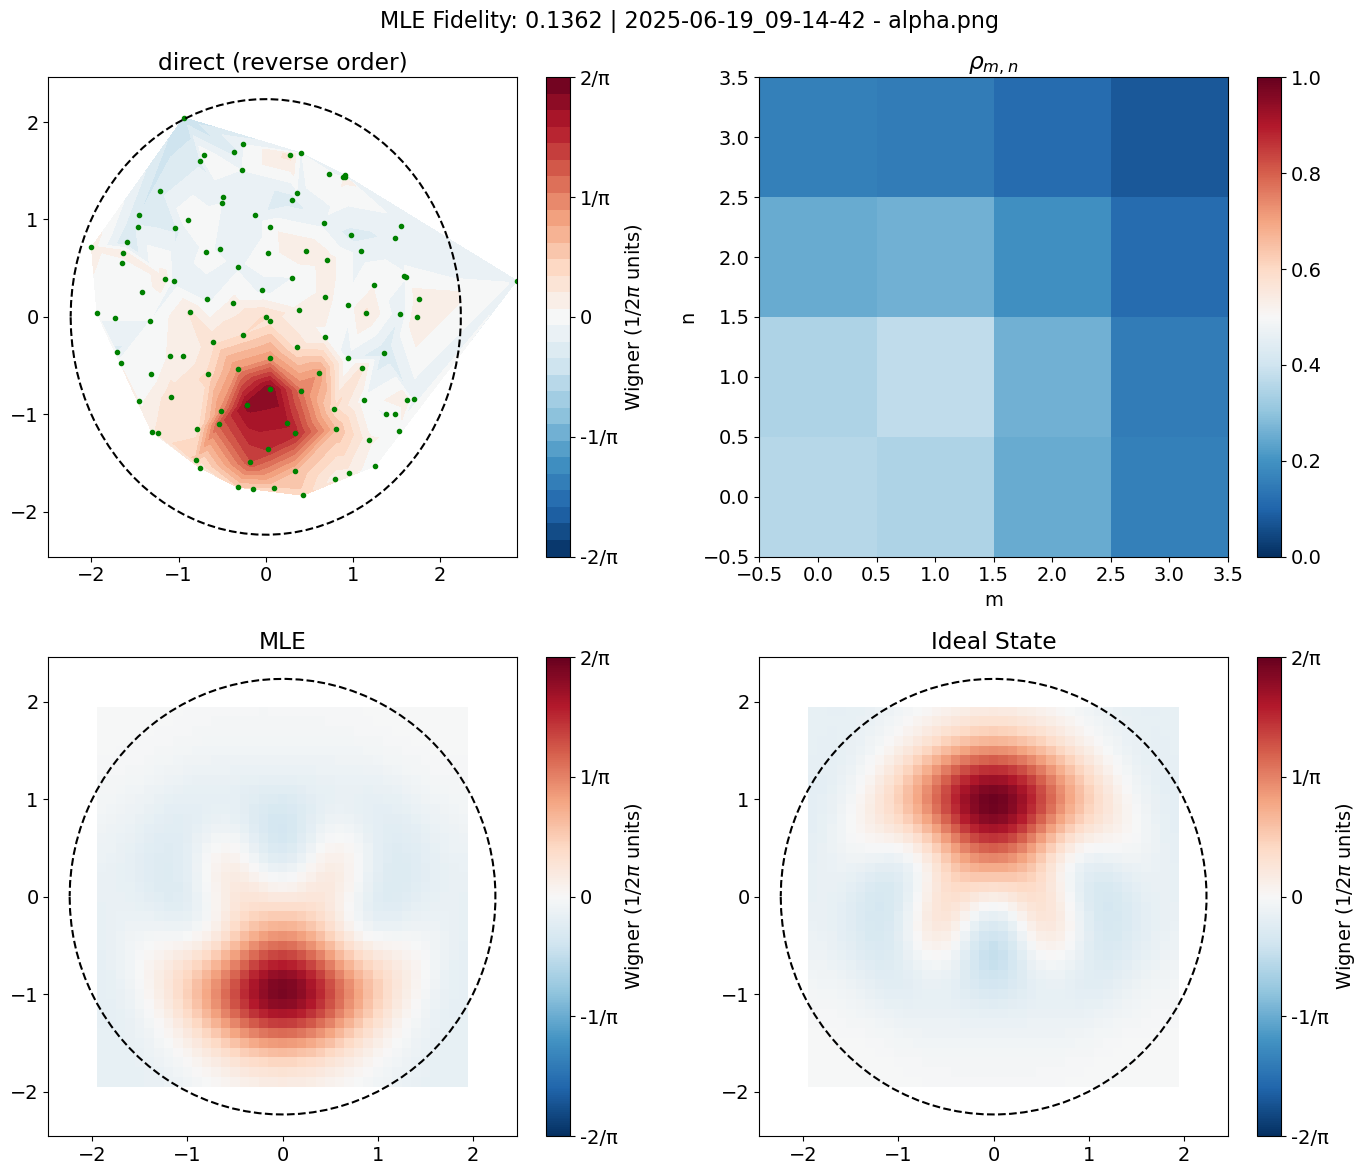

In [600]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = 'alpha')

## Wigner Tomography of |2> with swap

In [568]:
# adding g1-e1 and e1-f1 to the prepulse 
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['multiphoton', 'g1-e1', 'pi', 0])
prep_man_pi.append(['multiphoton', 'e1-f1', 'pi', 0])  

prep_man_pi.append(['multiphoton', 'f1-g2', 'pi', 0])   # This is the prepulse for the manipulate mode
prep_man_pi.append(['storage', 'M1-S1', 'pi', 0]) 
prep_man_pi.append(['storage', 'M1-S1', 'pi', 0]) 
## convert it to low level pulse 
pulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()


# post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
# post_pulse
pulse

[[3567.346809921427,
  3423.9866806417763,
  2005.9,
  3567.055708,
  3423.724467,
  2005.32,
  348.9178150893526,
  348.9178150893526],
 [10409, 8221, 15000, 10167, 8276, 15000, 3000, 3000],
 [0.0,
  0.0,
  1.082052141523385,
  0,
  0,
  0.762198579,
  0.9561816662492874,
  0.9561816662492874],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 0, 2, 2, 0, 1, 1],
 ['g', 'g', 'flat_top', 'gauss', 'gauss', 'flat_top', 'flat_top', 'flat_top'],
 [0.035, 0.035, 0.005, 0.035, 0.035, 0.005, 0.005, 0.005]]

In [569]:
wigner_exp_2_swap = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 1000,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based = False,
    relax_delay=8000
)

man mode no: 1


  0%|          | 0/261 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00015_WignerTomography1ModeExperiment.h5


(1000, 261)


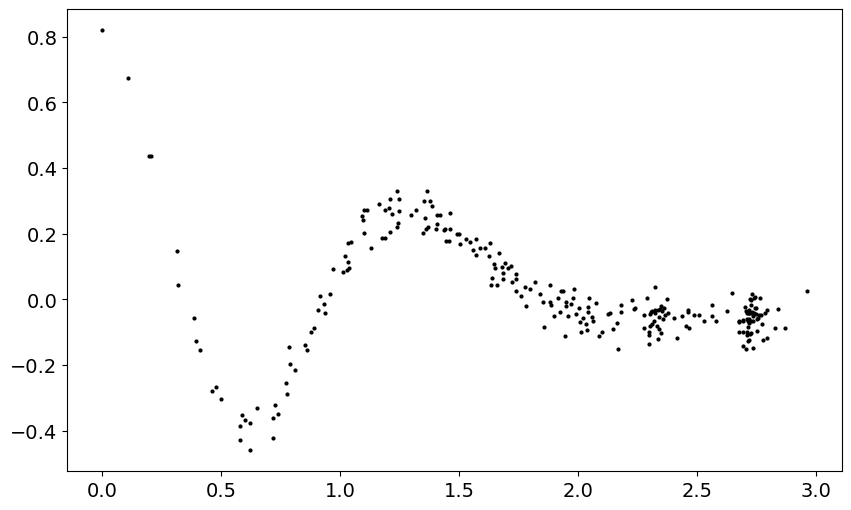

In [570]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_2_swap.data, config=wigner_exp_2_swap.cfg, mode_state_num=10, alphas = wigner_exp.data['alpha'])
initial_state = (fock(wigner_analysis.m, 2)  ).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g
plt.plot(np.abs(wigner_exp_2_swap.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

MLE Fidelity:  0.92229378343253
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.9223')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-19_06-28-07_2_after_storage_swap.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-19.md


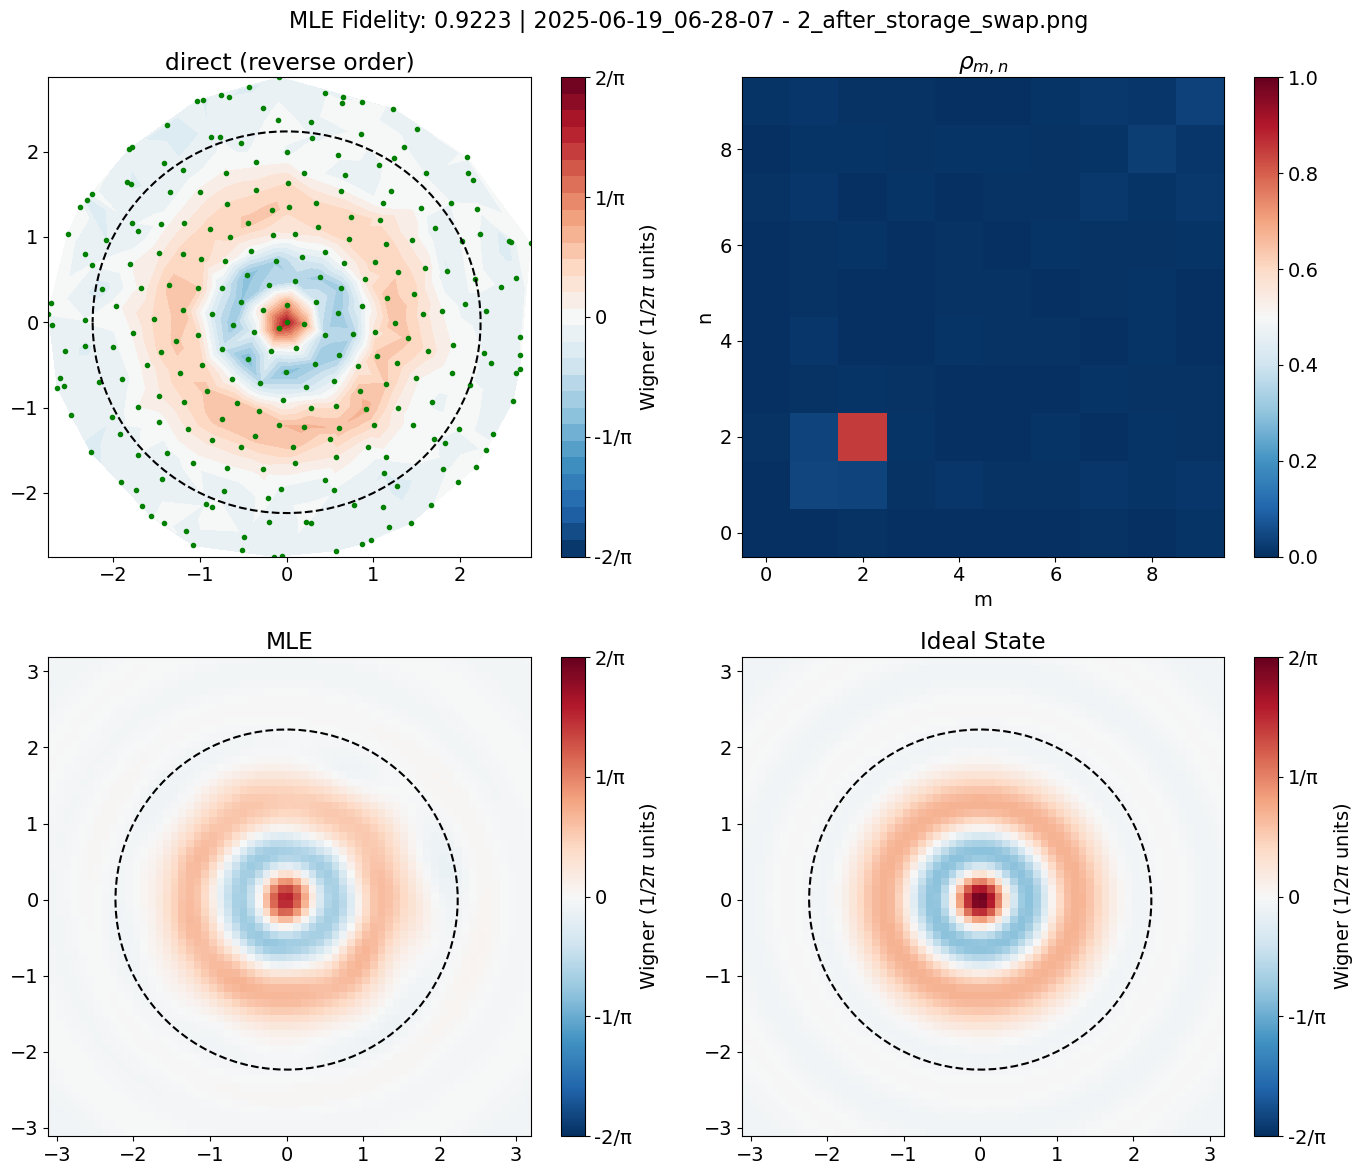

In [571]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '2 after storage swap')

## Wigner Tomography of |0+2>

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_02_pulse = []
prep_02_pulse.append(['qubit', 'ge', 'hpi', 0]) # g0 + e0 
prep_02_pulse.append(['qubit', 'ef', 'pi', 0]) # g0 + f0 
prep_02_pulse.append(['qubit', 'ge', 'pi', 0])# e0 + f0
prep_02_pulse.append(['multiphoton', 'f0-g1', 'pi', 0]) # e0 + g1 
prep_02_pulse.append(['multiphoton', 'g0-e0', 'pi', 0]) # g0 + e1
prep_02_pulse.append(['multiphoton', 'e1-f1', 'pi', 0]) # g0 + f1 
prep_02_pulse.append(['multiphoton', 'f1-g2', 'pi', 0]) # g0 + g2
prep_02_pulse
## convert it to low level pulse 
pulse_02 = mm_base_dummy.get_prepulse_creator(prep_02_pulse).pulse.tolist()
pulse_02

[['qubit', 'ge', 'hpi', 0],
 ['qubit', 'ef', 'pi', 0],
 ['qubit', 'ge', 'pi', 0],
 ['multiphoton', 'f0-g1', 'pi', 0],
 ['multiphoton', 'g0-e0', 'pi', 0],
 ['multiphoton', 'e1-f1', 'pi', 0],
 ['multiphoton', 'f1-g2', 'pi', 0]]

## Wigner Tomography of |0> + |1>

### Debugging

##### Histogram Prepulse

In [700]:
def do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    preloaded_pulses=False,
    use_arb_waveform=False,
    expts_base_inst=None,
    expt_path=None,
    config_path=None,
    config_thisrun=None,
    relax_delay=2500
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubits': qubits,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'preloaded_pulses': preloaded_pulses,
        'use_arb_waveform': use_arb_waveform
    }
    histogram_exp = expts_base_inst.meas.single_qubit.single_shot_prepulse.HistogramPrepulseExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='HistogramPrepulseExperiment', config_file=config_path
    )
    histogram_exp.cfg = AttrDict(deepcopy(config_thisrun))
    histogram_exp.cfg.expt = expt_cfg
    histogram_exp.go(analyze=False, display=False, progress=True, save=True)
    return histogram_exp


In [703]:
historgam_exp = do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    expts_base_inst=expts_base_inst,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    config_thisrun=expts_base_inst.config_thisrun,
    prepulse=True,
    gate_based=True,
    pre_sweep_pulse=[['qubit', 'ge', 'hpi', 0]],  # Use the prepulse pulse created above
)

[[3567.346809921427]
 [4852]
 [0.0]
 [0]
 [2]
 ['gauss']
 [0.035]]


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00003_HistogramPrepulseExperiment.h5


In [704]:
historgam_exp.data['I'].shape

(10000,)

Proportion of points below threshold -314: 0.529 (5295/10000)


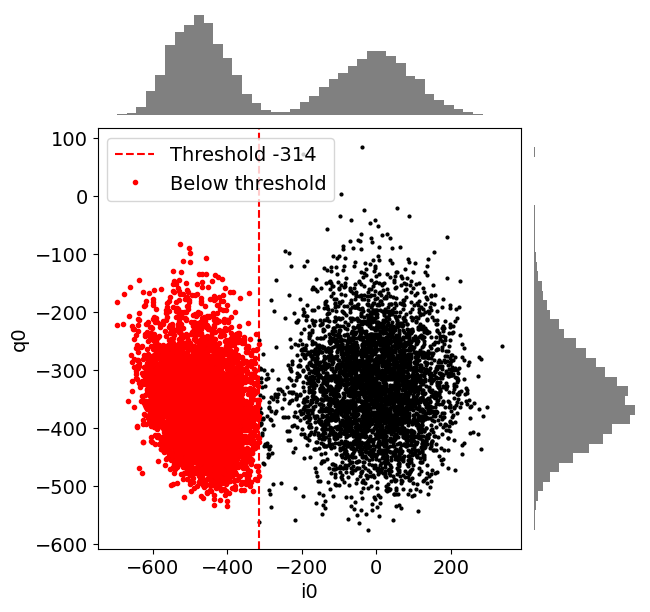

In [705]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = historgam_exp.data['I']
y = historgam_exp.data['Q']



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -314
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [645]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

[[3567.346809921427, 3423.9866806417763, 2005.9],
 [4636, 8221, 15000],
 [0.0, 0.0, 1.082052142],
 [0, 0, 0],
 [2, 2, 0],
 ['g', 'g', 'flat_top'],
 [0.035, 0.035, 0.005]]

In [652]:
# choose alphas along 3 axes 
alpha_list = np.linspace(0, 1, 10) 
phase_across_three_axes = np.array([0, 90, 180])  # in degrees
alphas = []
for phase in phase_across_three_axes:
    alphas.append(alpha_list * np.exp(1j * np.deg2rad(phase)))
alpha_list_full = np.concatenate(alphas)
alpha_list_full
f_path = expts_base_inst.expt_path + '\\alphas.npy'
np.save(f_path, alpha_list_full)


In [653]:
alpha_list_full

array([ 0.00000000e+00+0.00000000e+00j,  1.11111111e-01+0.00000000e+00j,
        2.22222222e-01+0.00000000e+00j,  3.33333333e-01+0.00000000e+00j,
        4.44444444e-01+0.00000000e+00j,  5.55555556e-01+0.00000000e+00j,
        6.66666667e-01+0.00000000e+00j,  7.77777778e-01+0.00000000e+00j,
        8.88888889e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  6.80359333e-18+1.11111111e-01j,
        1.36071867e-17+2.22222222e-01j,  2.04107800e-17+3.33333333e-01j,
        2.72143733e-17+4.44444444e-01j,  3.40179666e-17+5.55555556e-01j,
        4.08215600e-17+6.66666667e-01j,  4.76251533e-17+7.77777778e-01j,
        5.44287466e-17+8.88888889e-01j,  6.12323400e-17+1.00000000e+00j,
       -0.00000000e+00+0.00000000e+00j, -1.11111111e-01+1.36071867e-17j,
       -2.22222222e-01+2.72143733e-17j, -3.33333333e-01+4.08215600e-17j,
       -4.44444444e-01+5.44287466e-17j, -5.55555556e-01+6.80359333e-17j,
       -6.66666667e-01+8.16431199e-17j, -7.77777778

In [668]:
# Now doing wigner tomography at these 3 points of 0 + 1
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 5000,
    displacement_path=f_path,
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False,
    relax_delay=2500
)

man mode no: 1


  0%|          | 0/30 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00025_WignerTomography1ModeExperiment.h5


In [669]:
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=10, alphas = wigner_exp_01.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g
wigner_expec = 2/np.pi * (p_g - p_e)  # Wigner expectation value

(5000, 30)


In [670]:
wigner_expec

array([0.08557926, 0.1117689 , 0.17499438, 0.20515214, 0.22314098,
       0.27287484, 0.261235  , 0.24377524, 0.2257864 , 0.16070913,
       0.10250994, 0.11917607, 0.15912188, 0.18531151, 0.17896251,
       0.25462145, 0.22076011, 0.23345811, 0.17869797, 0.17393621,
       0.11203344, 0.09430914, 0.12367328, 0.13372587, 0.15621192,
       0.20726848, 0.20859119, 0.20356489, 0.16361909, 0.15224379])

slice(0, 10, None)
slice(10, 20, None)
slice(20, 30, None)


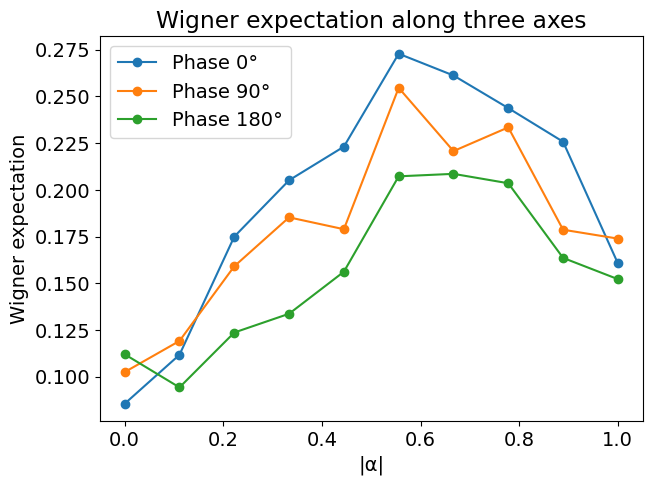

In [671]:
import numpy as np

wigner_exp_01.data['alpha']
# the array above contains alphas along the three axes, for each axes plot the corresponding wigner exppec
# I expec 3 traces on a single plot, one for each angle 
import matplotlib.pyplot as plt

alphas = wigner_exp_01.data['alpha']
wigner_expec = 2/np.pi * (p_g - p_e)

# There are 3 axes, so split the data accordingly
num_axes = 3
N = len(alphas) // num_axes

plt.figure(figsize=(7, 5))
for i, phase in enumerate(phase_across_three_axes):
    idx = slice(i*N, (i+1)*N)
    print(idx)
    plt.plot(np.abs(alphas[idx]), wigner_expec[idx], 'o-', label=f'Phase {phase}°')
plt.xlabel('|α|')
plt.ylabel('Wigner expectation')
plt.title('Wigner expectation along three axes')
plt.legend()
plt.show()

In [661]:
np.shape(wigner_exp_01.data['i0'])

(30, 1, 1000)

Proportion of points below threshold -300: 0.575 (575/1000)


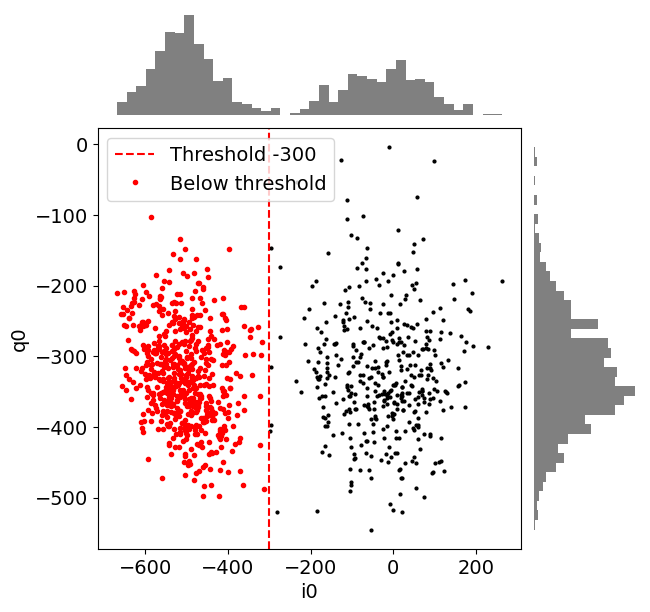

In [667]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = wigner_exp_01.data['i0'][0][0]
y = wigner_exp_01.data['q0'][0][0]



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -300
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [ ]:
# 

In [663]:
wigner_exp_01.cfg.device.readout

{'trig_offset': [450],
 'frequency': [748.8],
 'gain': [800],
 'phase': [29.79028008324773],
 'threshold': [-301.7609374000881],
 'threshold_list': [[-301.7609374000881]],
 'man1_drive_list': [0.0],
 'man2_drive_list': [0.0],
 'readout_length': [1.5],
 'relax_delay': [2500],
 'confusion_matrix_with_reset': [0.9964530022802125,
  0.0035469977197875036,
  0.013768302080657598,
  0.9862316979193424],
 'confusion_matrix_without_reset': [0.9886,
  0.011399999999999966,
  0.026,
  0.974],
 'Ie': [-11.637201631964007],
 'Ig': [-501.760937400088]}

### Normal

In [550]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

[[3567.346809921427, 3423.9866806417763, 2005.9],
 [4636, 8221, 15000],
 [0.0, 0.0, 1.082052142],
 [0, 0, 0],
 [2, 2, 0],
 ['g', 'g', 'flat_top'],
 [0.035, 0.035, 0.005]]

In [552]:
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 200,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False
)

man mode no: 1


  0%|          | 0/261 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00012_WignerTomography1ModeExperiment.h5


In [553]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=10, alphas = wigner_exp.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

(200, 261)


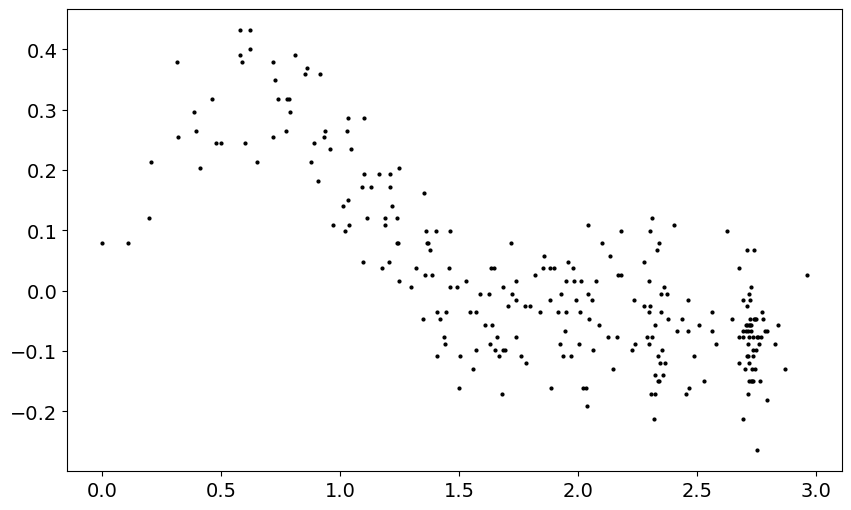

In [554]:
plt.plot(np.abs(wigner_exp_01.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

MLE Fidelity:  0.7169261636139644
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.7169')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-19_05-32-41_0+1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-19.md


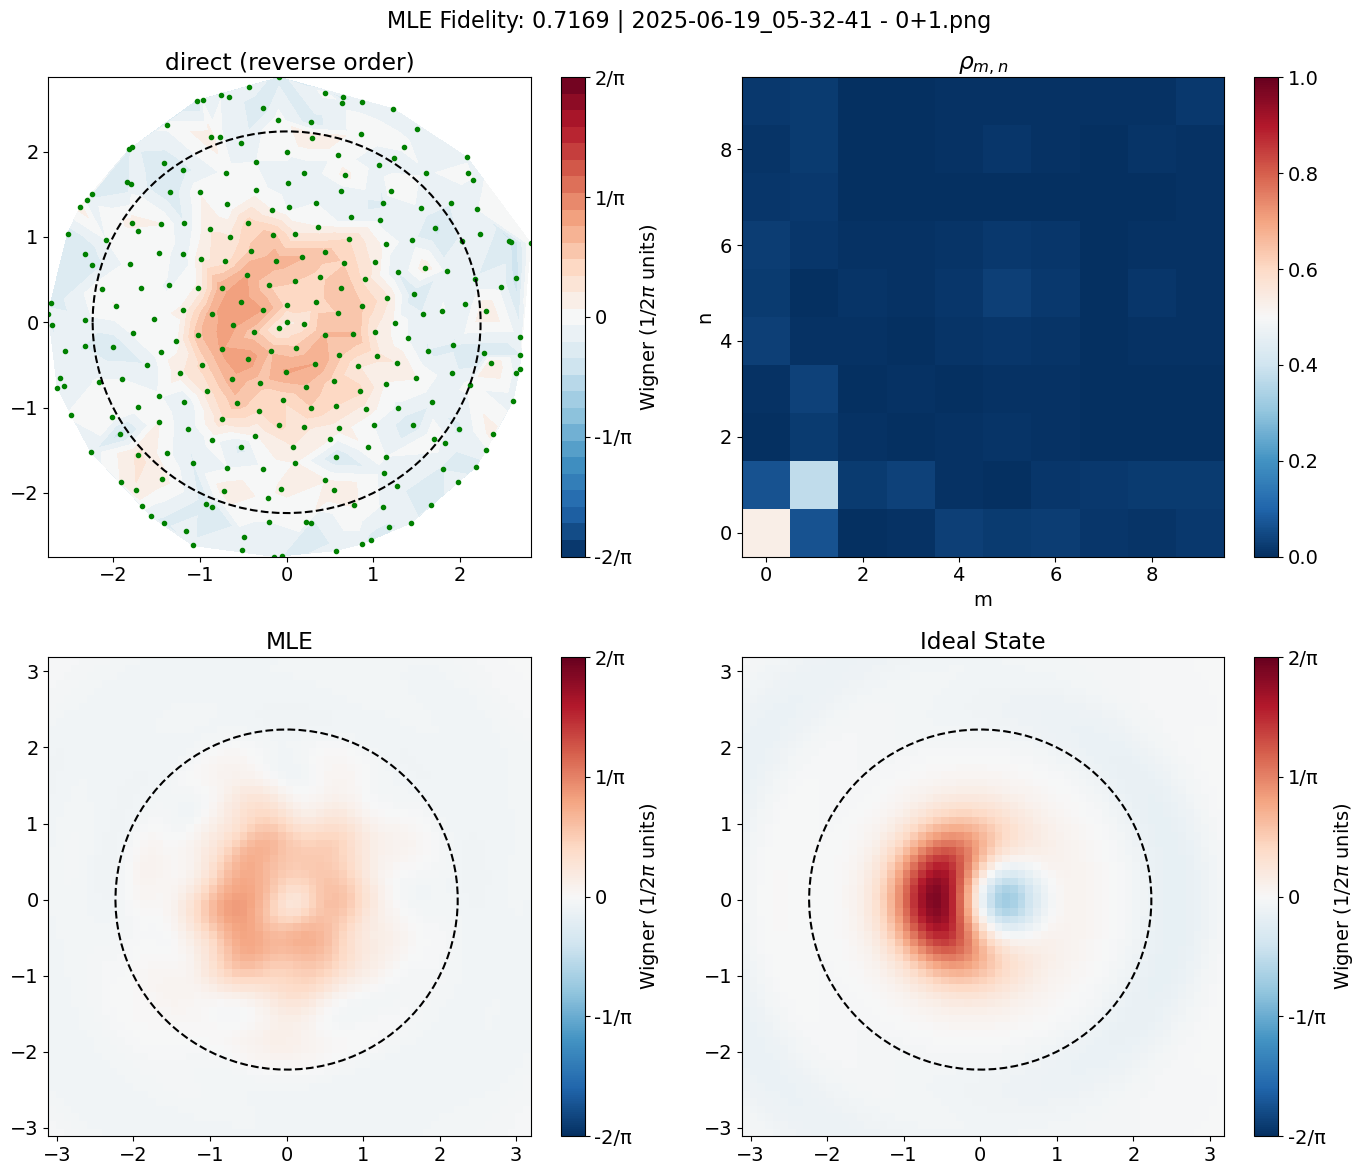

In [555]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+1')

In [431]:
wigner_exp_02 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 200,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_02,
    gate_based = False
)

man mode no: 1


  0%|          | 0/261 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00009_WignerTomography1ModeExperiment.h5


In [469]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_02.data, config=wigner_exp_02.cfg, mode_state_num=10, alphas = wigner_exp.data['alpha'])
initial_state = (fock(wigner_analysis.m, 2)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

(200, 261)


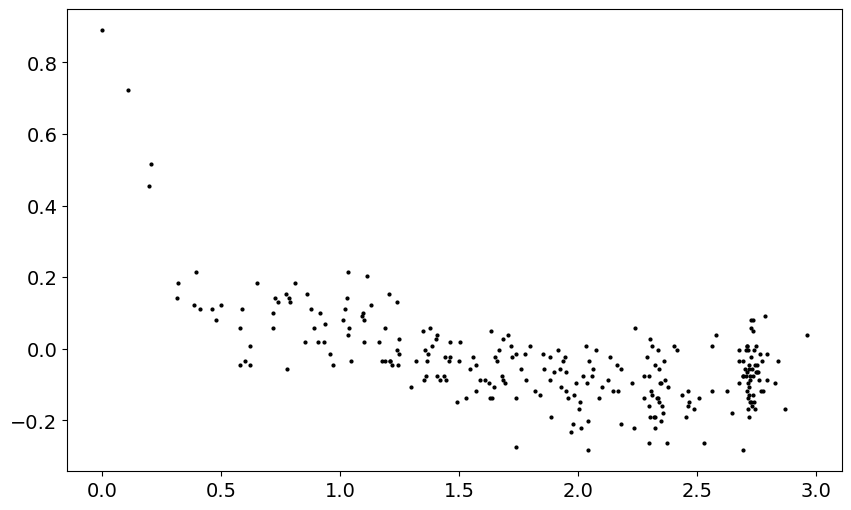

In [433]:
plt.plot(np.abs(wigner_exp_02.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

In [470]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+2')

MLE Fidelity:  0.5187873609386402
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.5188')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-18_17-37-35_0+2.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-18.md


In [415]:
expts_base_inst.soc.deg2reg(180, 0)

2147483648

In [413]:
expts_base_inst.soc.deg2reg(180)

2147483648

In [ ]:
from qutip import wigner, fock, displace
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter

import matplotlib.pyplot as plt




# Define parameters
N = 15  # Hilbert space dimension
n = 2 # Fock state |n>
xvec = np.linspace(-3, 3, 200)
yvec = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(xvec, yvec)
alpha = X + 1j * Y

# Create Fock state
psi = fock(N, n)

# Compute Wigner function
W = wigner(psi, xvec, yvec)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(X, Y, W, cmap='RdBu_r', shading='auto', vmin=-2/np.pi, vmax=2/np.pi)
ax.set_xlabel('Re(α)')
ax.set_ylabel('Im(α)')
ax.set_title(f'Wigner function for Fock state |{n}>')
cb = fig.colorbar(c, ax=ax)
cb.set_label('Wigner function')
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
plt.show()

# Multiphoton Calibration

## Qubit Calibvration with |1> in man

### g0-e0

In [305]:
def do_amplitude_rabi(
    config_thisrun,
    expt_path,
    config_path,
    start=50,
    step=160,
    expts=151,
    reps=100,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    postpulse=False,
    gate_based=False,
    relax_delay=2500,
    if_ef=False
):
    """Run the amplitude Rabi experiment with all config params as function arguments."""
    amprabi = expts_base_inst.meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))
    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    if sigma_test is None:
        sigma_test = pulse_ge.sigma[0]

    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_after = True

    amprabi.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        sigma_test=sigma_test,
        qubit=qubit,
        pulse_type=pulse_type,
        drag_beta=drag_beta,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_after,
        checkZZ=checkZZ,
        checkEF=checkEF,
        qubits=qubits,
        flat_length=flat_length,
        normalize=normalize,
        single_shot=single_shot,
        singleshot_reps=singleshot_reps,
        span=span,
        user_defined_freq=user_defined_freq,
        prepulse=prepulse,
        postpulse=postpulse,
        pre_sweep_pulse=pre_sweep_pulse if pre_sweep_pulse is not None else [],
        post_sweep_pulse=post_sweep_pulse if post_sweep_pulse is not None else [],
        gate_based=gate_based
    )
    amprabi.cfg.device.readout.relax_delay = [relax_delay]
    amprabi.go(analyze=False, display=False, progress=True, save=True)
    return amprabi


In [310]:
amprabi = do_amplitude_rabi(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    sigma_test=0.02,
    step = 300,
    expts=101,
    qubit=0,
    user_defined_freq=[False, 3567.063422],
    prepulse=False,
    gate_based=False,
    pre_sweep_pulse=[]
)

  0%|          | 0/10100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00016_AmplitudeRabiExperiment.h5


Attempted to init fitparam 4 to -208.5192876623377, which is out of bounds -347.806341991342 to -311.84599567099565. Instead init to -329.82616883116884
Attempted to init fitparam 4 to -329.82616883116884, which is out of bounds 319.6206575993079 to 599.4734264721349. Instead init to 459.54704203572135
Pi gain from avgi data [dac units]: 19448
	Pi/2 gain from avgi data [dac units]: 9906
Pi gain from avgq data [dac units]: 96924
	Pi/2 gain from avgq data [dac units]: 62228


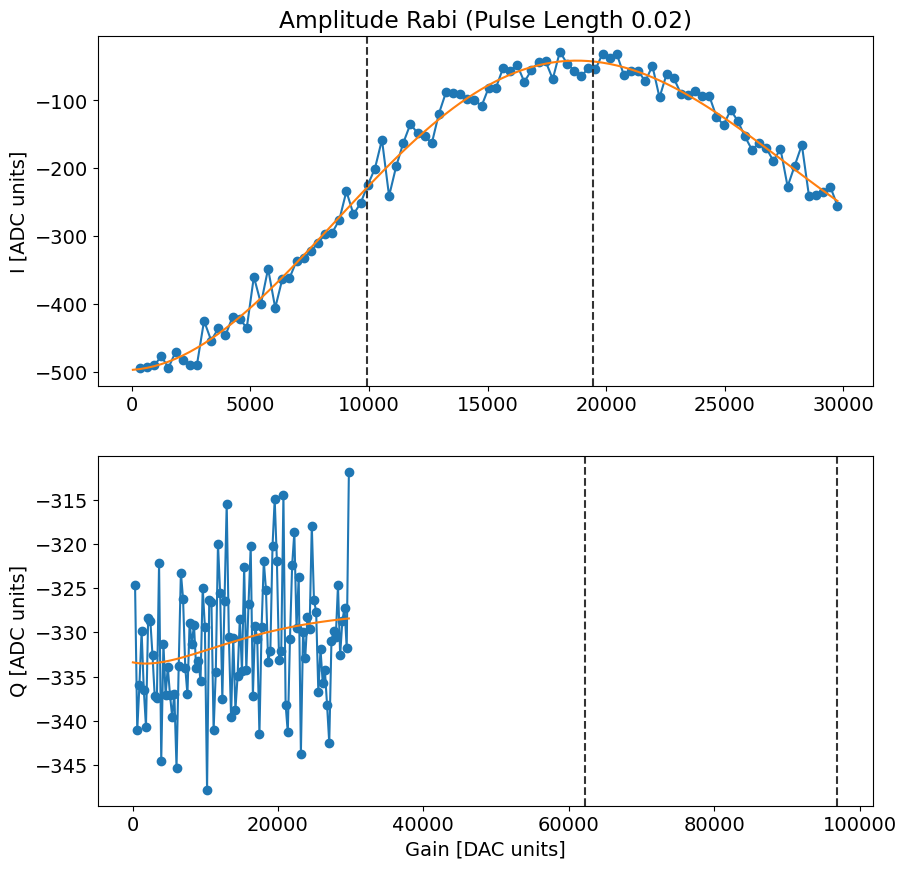

In [311]:
amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)

### g1-e1

#### Frequency

In [91]:
def do_t2_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    step_size=0.05,
    if_ef=False,
    ef_init=True, # redundant
    start=0.01,
    expts=200,
    ramsey_freq=0.2,
    reps=100,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=False,
    man_reset=True,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=2500
):
    """Run the T2 Ramsey experiment with all config params as function arguments."""
    t2ramsey = expts_base_inst.meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False

    t2ramsey.cfg.expt = {
        'start': start,
        'step': step_size,
        'expts': expts,
        'ramsey_freq': ramsey_freq,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'checkEF': checkEF,
        'user_defined_freq': user_defined_freq,
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': f0g1_cavity,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': False if pre_sweep_pulse is None else True if prepulse is None else prepulse,
        'postpulse': False if post_sweep_pulse is None else True if postpulse is None else postpulse,
        'pre_active_reset_pulse': pre_active_reset_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'gate_based': gate_based,
        'advance_phase': advance_phase,
        'echoes': echoes
    }

    t2ramsey.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis



# def update_t2_ramsey_ge(t2ramsey, config_thisrun):
#     """Update the configuration based on T2 Ramsey experiment results."""
#     config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
#     print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])


In [37]:
# prepare a photon in man
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)

In [38]:
prep_man_pi

[['qubit', 'ge', 'pi', 0], ['qubit', 'ef', 'pi', 0], ['man', 'M1', 'pi', 0]]

In [69]:
old_sigma = expts_base_inst.config_thisrun.device.qubit.pulses.pi_ge.sigma[0]
old_gain = expts_base_inst.config_thisrun.device.qubit.pulses.hpi_ge.gain[0]
old_freq = expts_base_inst.config_thisrun.device.qubit.f_ge[0]

In [63]:
old_freq + 0.4703782780138798  -0.2

3567.6184677710157

In [88]:
# Run a Ramsey experiment and analyze the results
t2ramsey_ge_man_1 = do_t2_ramsey(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file, 
    user_defined_freq=[True, 3567.0777112149876,  4648, old_sigma],
    prepulse = True, 
    gate_based = True,
    pre_sweep_pulse = prep_man_pi
    
)

fge is  3567.3480894930017
fef is  3423.9868524018493


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00285_RamseyExperiment.h5


In [ ]:
0.4703782780138798 -0

In [72]:
!pip show qick

No echoes in the data
Attempted to init fitparam 1 to 10, which is out of bounds 0.010101010101010102 to 1.5151515151515151. Instead init to 0.7626262626262627
Attempted to init fitparam 4 to -246.68725619439184, which is out of bounds -340.8940692640693 to -273.49502164502167. Instead init to -307.1945454545455
Using user defined frequency: 3567.0777112149876 MHz
Current pi pulse frequency: 3567.0777112149876
Fit frequency from I [MHz]: 0.2220032429159256 +/- 0.0006393561960834597
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.0557079720716
 	3567.4997144579033
T2 Ramsey from fit I [us]: 79.45054758425847
Fit frequency from Q [MHz]: 0.8943476395591837 +/- 0.02849736002051237
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3566.3833635754286
 	3568.172058854547
T2 Ramsey from fit Q [us]: 2.9700000000000006


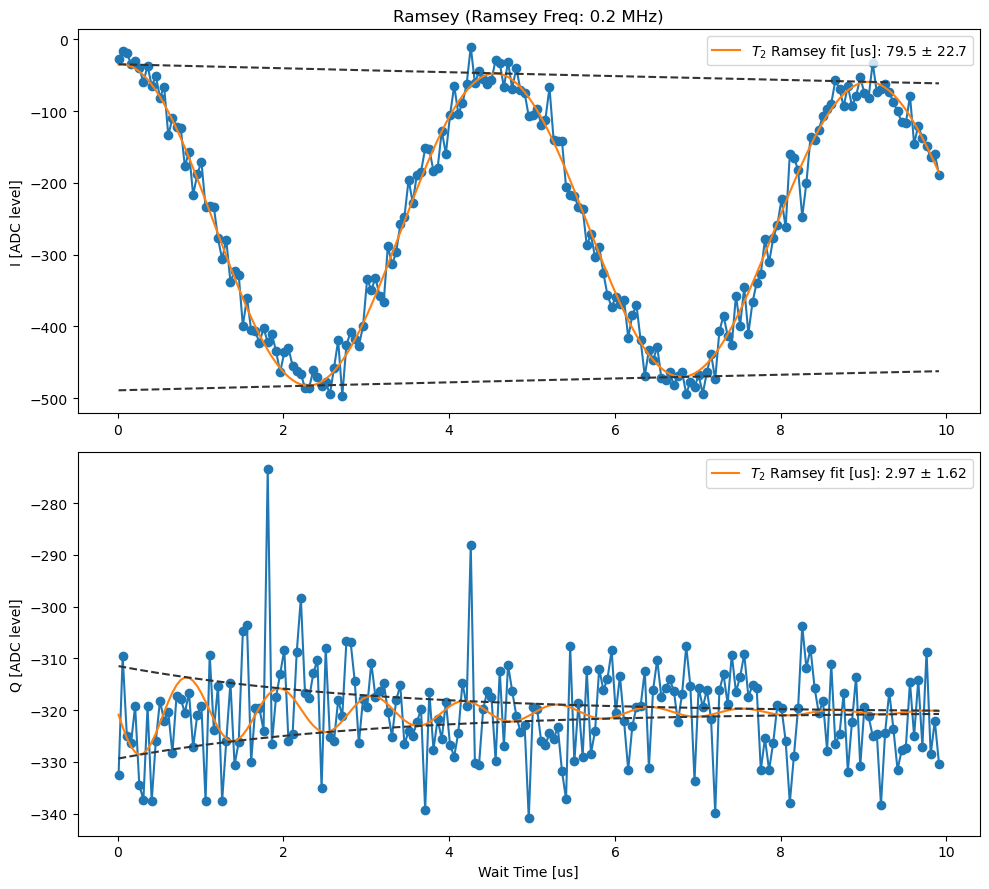

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-16_14-41-19_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-16.md


In [89]:
t2ramsey_ge_man_1.analyze(fitparams=[500, 10, None, 200, None, None])
t2ramsey_ge_man_1.display()

In [74]:
# H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00281_RamseyExperiment.h5
# from multimode_expts.fit_display_classes import RamseyFitting
# temp_data, attrs, fname = expts_base_inst.prev_data(filename = '00283_RamseyExperiment.h5')
# ramsey_analysis = RamseyFitting(temp_data, config=AttrDict(attrs['config']))
# ramsey_analysis.analyze(fitparams=[500, 10, None, 200, None, None])
# ramsey_analysis.display(title_str='Ramsey Analysis from Previous Data')

In [ ]:
# expts_base_inst.ds_thisrun.append_dataset('qubit_g1_e1', 3567.0557079720716, np.NAN, 10167	4648)

#### Amplitude

In [85]:
def do_amplitude_rabi(
    config_thisrun,
    expt_path,
    config_path,
    start=50,
    step=160,
    expts=151,
    reps=100,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    postpulse=False,
    gate_based=False,
    relax_delay=2500,
    if_ef=False
):
    """Run the amplitude Rabi experiment with all config params as function arguments."""
    amprabi = expts_base_inst.meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))
    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    if sigma_test is None:
        sigma_test = pulse_ge.sigma[0]

    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_after = True

    amprabi.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        sigma_test=sigma_test,
        qubit=qubit,
        pulse_type=pulse_type,
        drag_beta=drag_beta,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_after,
        checkZZ=checkZZ,
        checkEF=checkEF,
        qubits=qubits,
        flat_length=flat_length,
        normalize=normalize,
        single_shot=single_shot,
        singleshot_reps=singleshot_reps,
        span=span,
        user_defined_freq=user_defined_freq,
        prepulse=prepulse,
        postpulse=postpulse,
        pre_sweep_pulse=pre_sweep_pulse if pre_sweep_pulse is not None else [],
        post_sweep_pulse=post_sweep_pulse if post_sweep_pulse is not None else [],
        gate_based=gate_based
    )
    amprabi.cfg.device.readout.relax_delay = [relax_delay]
    amprabi.go(analyze=False, display=False, progress=True, save=True)
    return amprabi


In [97]:
amprabi = do_amplitude_rabi(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    sigma_test=old_sigma,
    qubit=0,
    user_defined_freq=[False, 3567.063422],
    prepulse=False,
    gate_based=True,
    pre_sweep_pulse=prep_man_pi
)

  0%|          | 0/15100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00012_AmplitudeRabiExperiment.h5


In [98]:
amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)

Attempted to init fitparam 4 to -304.74770505050503, which is out of bounds 318.44327491312004 to 604.8351025243501. Instead init to 461.63918871873506
Pi gain from avgi data [dac units]: 10387
	Pi/2 gain from avgi data [dac units]: 4728
Pi gain from avgq data [dac units]: 49003
	Pi/2 gain from avgq data [dac units]: 32262


### e1-f1

#### Frequency

In [ ]:
old_sigma = expts_base_inst.config_thisrun.device.qubit.pulses.pi_ge.sigma[0]
old_gain = expts_base_inst.config_thisrun.device.qubit.pulses.hpi_ge.gain[0]
old_freq = expts_base_inst.config_thisrun.device.qubit.f_ge[0]

In [ ]:
# adding g1-e1 to the prepulse 
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['qubit', 'ge', 'pi', 0])
## convert it to low level pulse 
pulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

# change to g1 - e1
pulse[0][-1] = 3567.05570797207  # g1 - e1 freq
pulse[1][-1] = 10167 # gain 

post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
post_pulse

In [110]:
post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
post_pulse

[[3567.05570797207], [10167], [0.0], [0], [2], ['g'], [0.035]]

In [113]:
# Run a Ramsey experiment and analyze the results
t2ramsey_e1f1 = do_t2_ramsey(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file, 
    user_defined_freq=[True, 3423.742663513891, 3858, old_sigma],
    prepulse = True, 
    postpulse = True,
    gate_based = False,
    pre_sweep_pulse = pulse,
    post_sweep_pulse=post_pulse
)

fge is  3567.3480894930017
fef is  3423.9868524018493


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00288_RamseyExperiment.h5


No echoes in the data
Using user defined frequency: 3423.742663513891 MHz
Current pi pulse frequency: 3423.742663513891
Fit frequency from I [MHz]: 0.21819615805732137 +/- 0.0006288197140199255
Suggested new pi pulse frequency from fit I [MHz]:
 	3423.7244673558334
 	3424.1608596719484
T2 Ramsey from fit I [us]: 50.45873913865472
Fit frequency from Q [MHz]: 0.010101010134556688 +/- 0.46366279903891305
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3423.9325625037563
 	3423.9527645240255
T2 Ramsey from fit Q [us]: 2.9700000000000006


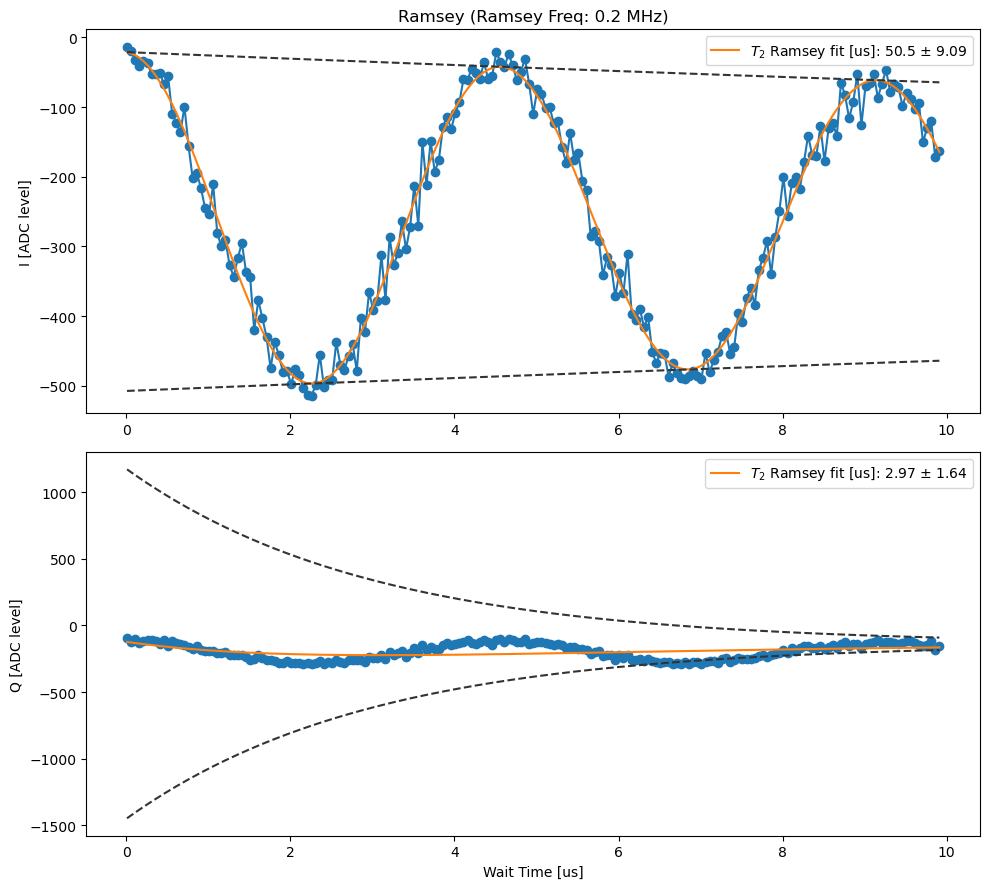

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-16_15-11-03_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-16.md


In [115]:
t2ramsey_e1f1.analyze(fitparams=[500, 0.1, None, 200, None, None])
t2ramsey_e1f1.display()

#### Amplitude

In [116]:
amprabi_e1f1 = do_amplitude_rabi(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    sigma_test=old_sigma,
    qubit=0,
    user_defined_freq=[True, 3423.7244673558334],
    prepulse=True,
    postpulse=True,
    gate_based=False,
    pre_sweep_pulse=pulse,
    post_sweep_pulse=post_pulse
)


  0%|          | 0/15100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00013_AmplitudeRabiExperiment.h5


Attempted to init fitparam 4 to -283.76188008658005, which is out of bounds 97.54788363175764 to 600.1378881791388. Instead init to 348.8428859054482
Pi gain from avgi data [dac units]: 8276
	Pi/2 gain from avgi data [dac units]: 3859
Pi gain from avgq data [dac units]: 130749
	Pi/2 gain from avgq data [dac units]: 71149


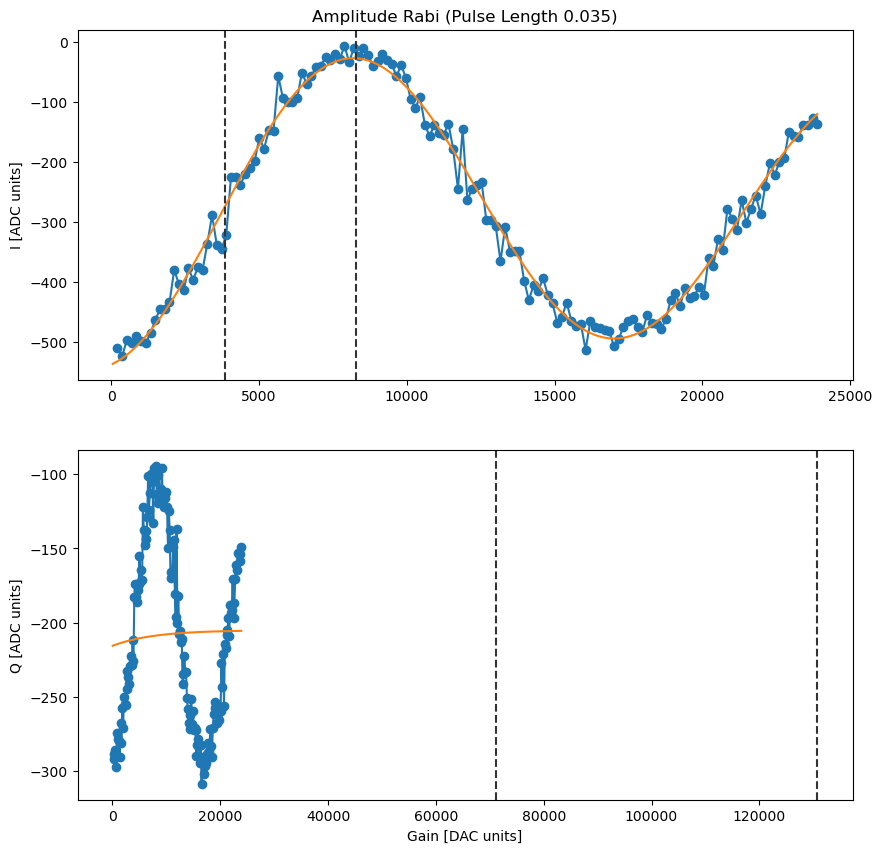

In [118]:
amprabi_e1f1.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
amprabi_e1f1.display(title_str='Amplitude Rabi_ge', save_fig=True)

In [6]:
expts_base_inst.load_storage_man_swap_dataset()

(<multimode_expts.dataset.storage_man_swap_dataset at 0x1c239c30b80>,
 'C:\\_Lib\\python\\multimode_expts\\man1_storage_swap_dataset_copy.csv')

### f1-g2

#### Find Frequency pulse probe

In [130]:
def do_pulse_probe_f0g1(
    config_thisrun,
    ds_thisrun,
    man_mode_no=1,
    start=2003,
    step=0.01,
    expts=500,
    reps=100,
    rounds=1,
    length=1,
    gain=5000,
    pulse_type='gaussian',
    qubit_f=False,
    qubits=[0],
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=200
):
    """
    Run the Pulse Probe F0g1 Spectroscopy experiment with configurable parameters.
    """
    qspec = expts_base_inst.meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=expts_base_inst.config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    if start is None:
        start = ds_thisrun.get_freq('M' + str(man_mode_no)) - 5
    if pre_sweep_pulse is None:
        pre_sweep_pulse = [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]

    qspec.cfg.expt = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'length': length,
        'gain': gain,
        'pulse_type': pulse_type,
        'qubit_f': qubit_f,
        'qubits': qubits,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse
    }

    qspec.cfg.device.readout.relax_delay = [relax_delay]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()



In [131]:
# adding g1-e1 and e1-f1 to the prepulse 
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['qubit', 'ge', 'pi', 0])
prep_man_pi.append(['qubit', 'ef', 'pi', 0])
## convert it to low level pulse 
pulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

# change to g1 - e1
pulse[0][-2] = 3567.05570797207  # g1 - e1 freq
pulse[1][-2] = 10167 # gain 

pulse[0][-1] = 3423.724467  # e1 - f1 freq
pulse[1][-1] = 8276 # gain 

post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
post_pulse

[[3423.724467], [8276], [0.0], [0], [2], ['gauss'], [0.035]]

In [132]:
pulse

[[3567.3480894930017,
  3423.9868524018493,
  2005.9,
  3567.05570797207,
  3423.724467],
 [10409, 8221, 15000, 10167, 8276],
 [0.0, 0.0, 1.082052141523385, 0.0, 0.0],
 [0, 0, 0, 0, 0],
 [2, 2, 0, 2, 2],
 ['gauss', 'gauss', 'flat_top', 'gauss', 'gauss'],
 [0.035, 0.035, 0.005, 0.035, 0.035]]

  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00051_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2005.8505231650765, HWHM 0.46381646451686664
Found peak in I at [MHz] 2005.8476572248726, HWHM 0.46425041270286843
Found peak in Q at [MHz] 2005.8564292921956, HWHM 0.47451573226222515


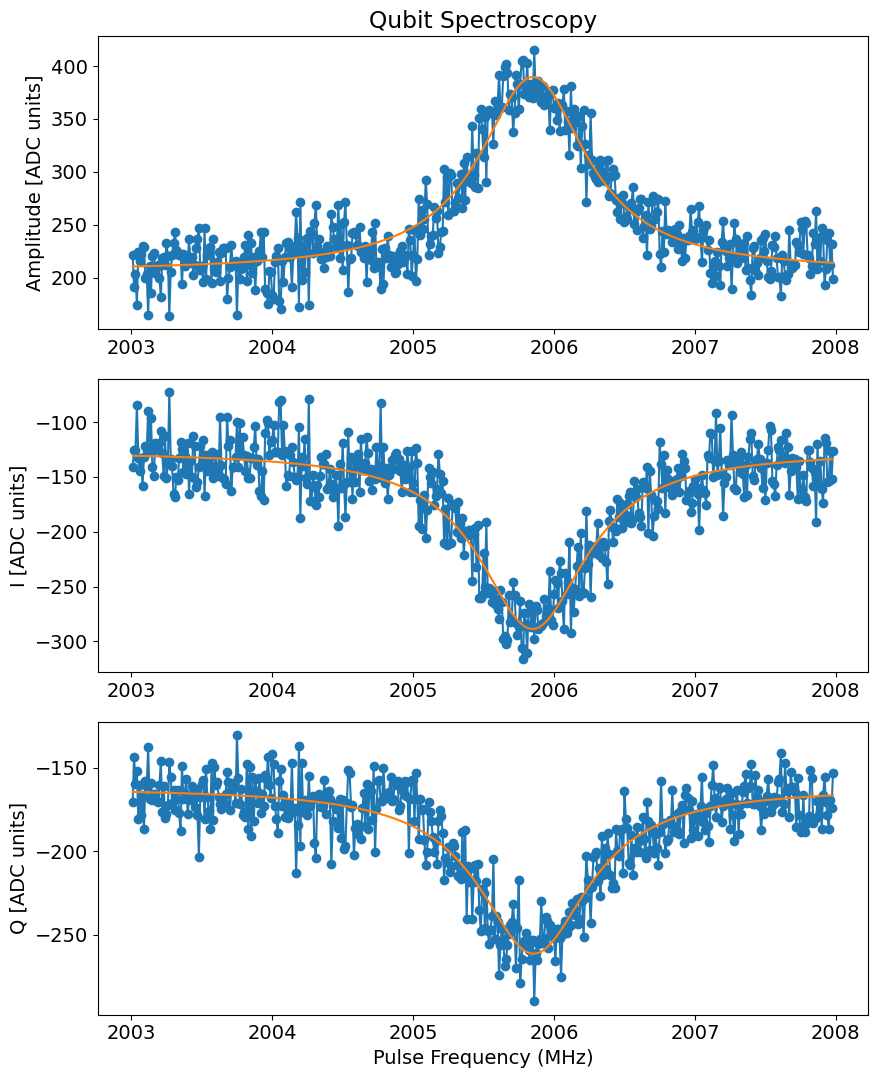

In [133]:
man_spec = do_pulse_probe_f0g1(expts_base_inst.config_thisrun,
                                expts_base_inst.ds_thisrun, 
                                man_mode_no = 1, 
                                prepulse = False, pre_sweep_pulse=pulse,)
analyze_and_display_pulse_probe_f0g1(man_spec)
        

#### Find Frequency (Chevron)


In [ ]:
%matplotlib inline

In [134]:
def do_length_rabi_f1g2_sweep(
    config_thisrun,
    expt_path,
    config_path,
    freq_start,
    freq_stop,
    freq_step,
    start=2,
    step=0.05,
    qubits=[0],
    expts=101,
    reps=100,
    rounds=1,
    gain=15000,
    ramp_sigma=0.005,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    check_man_reset=[False, 0],
    check_man_reset_pi=[],
    prepulse=False,
    postpulse=False,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    err_amp_reps=0
):
    """Run the Length Rabi General F0g1 Experiment Sweep with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(
        soccfg=expts_base_inst.soc,
        path=expt_path,
        prefix=sweep_experiment_name,
        config_file=config_path,
        exp_param_file=expts_base_inst.exp_param_file,
        config_thisrun=config_thisrun
    )

    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop': freq_stop,
        'freq_step': freq_step,
        'start': start,
        'step': step,
        'qubits': qubits,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'gain': gain,
        'ramp_sigma': ramp_sigma,
        'use_arb_waveform': use_arb_waveform,
        'pi_ge_before': pi_ge_before,
        'pi_ef_before': pi_ef_before,
        'pi_ge_after': pi_ge_after,
        'normalize': normalize,
        'active_reset': active_reset,
        'check_man_reset': check_man_reset,
        'check_man_reset_pi': check_man_reset_pi,
        'prepulse': prepulse,
        'postpulse': postpulse,
        'post_sweep_pulse': post_sweep_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'err_amp_reps': err_amp_reps,
    }
    return eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)




In [135]:
# adding g1-e1 and e1-f1 to the prepulse 
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['qubit', 'ge', 'pi', 0])
prep_man_pi.append(['qubit', 'ef', 'pi', 0])
## convert it to low level pulse 
pulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

# change to g1 - e1
pulse[0][-2] = 3567.05570797207  # g1 - e1 freq
pulse[1][-2] = 10167 # gain 

pulse[0][-1] = 3423.724467  # e1 - f1 freq
pulse[1][-1] = 8276 # gain 

post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
post_pulse

[[3423.724467], [8276], [0.0], [0], [2], ['gauss'], [0.035]]

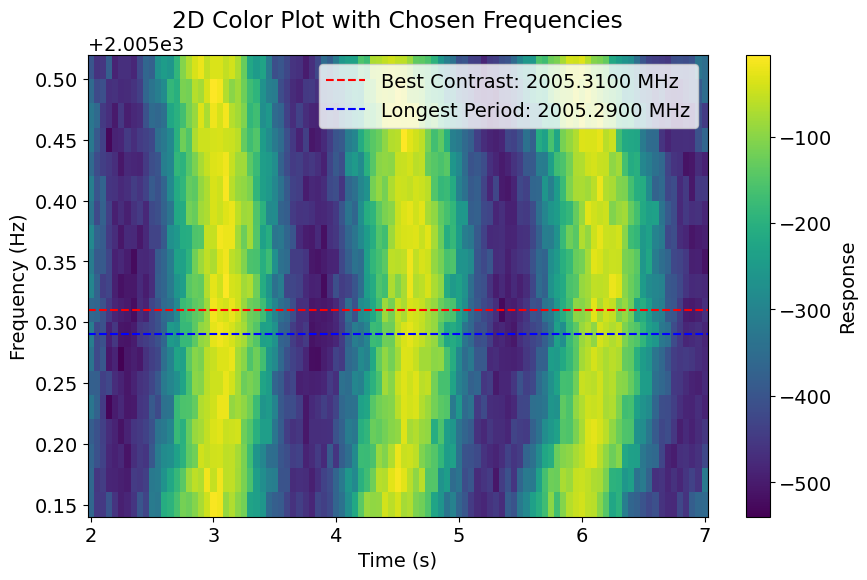

Index: 19 Freq. = 2005.5299999999995 GHz
Running experiment with config: configthisrun
{'start': 2, 'step': 0.05, 'qubits': [0], 'expts': 101, 'reps': 100, 'rounds': 1, 'gain': 15000, 'freq': 2005.5299999999995, 'use_arb_waveform': False, 'pi_ge_before': False, 'pi_ef_before': False, 'pi_ge_after': False, 'pi_ef_after': False, 'normalize': False, 'active_reset': False, 'check_man_reset': [False, 0], 'swap_lossy': False, 'check_man_reset_pi': [], 'prepulse': True, 'pre_sweep_pulse': [[3567.3480894930017, 3423.9868524018493, 2005.9, 3567.05570797207, 3423.724467], [10409, 8221, 15000, 10167, 8276], [0.0, 0.0, 1.082052141523385, 0.0, 0.0], [0, 0, 0, 0, 0], [2, 2, 0, 2, 2], ['gauss', 'gauss', 'flat_top', 'gauss', 'gauss'], [0.035, 0.035, 0.005, 0.035, 0.035]], 'err_amp_reps': 0}


KeyboardInterrupt: 

In [138]:
i = 0 
ds_thisrun = expts_base_inst.ds_thisrun
guess_freq = 2005.35
freq_start = guess_freq- 0.2
freq_stop = guess_freq + 0.2
freq_step = 0.02
man_chevrons_coarse = do_length_rabi_f1g2_sweep(expts_base_inst.config_thisrun, expts_base_inst.expt_path, expts_base_inst.config_file, 
                                                freq_start, freq_stop, freq_step,
                                                prepulse = True, 
                                                pre_sweep_pulse=pulse,
                                                postpulse = True ,
                                                post_sweep_pulse=post_pulse,
                                                )

In [267]:
(2.2-3.8)/2

-0.7999999999999998

#### Length

In [268]:
def do_length_rabi_f0g1_general(
    config_thisrun,
    ds_thisrun,
    expt_path,
    config_path,
    man_mode_no=1,
    start=None,
    step=0.05,
    qubits=[0],
    expts=150,
    reps=100,
    rounds=1,
    gain=15000,
    freq=None,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    man_reset=True,
    stor_reset=True,
    check_man_reset=[False, 0],
    swap_lossy=False,
    check_man_reset_pi=[],
    prepulse=True,
    postpulse=False,
    post_sweep_pulse=None,
    pre_sweep_pulse=None,
    err_amp_reps=0,
    relax_delay=2500
):
    """
    Run the Length Rabi General F0g1 Experiment with all config params as function arguments.
    """
    length_rabi = expts_base_inst.meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    if freq is None:
        freq = ds_thisrun.get_freq('M' + str(man_mode_no))
    if start is None:
        start = expts_base_inst.soc.cycles2us(3)
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []

    length_rabi.cfg.expt = dict(
        start=start,
        step=step,
        qubits=qubits,
        expts=expts,
        reps=reps,
        rounds=rounds,
        gain=gain,
        freq=freq,
        use_arb_waveform=use_arb_waveform,
        pi_ge_before=pi_ge_before,
        pi_ef_before=pi_ef_before,
        pi_ge_after=pi_ge_after,
        normalize=normalize,
        active_reset=active_reset,
        man_reset=man_reset,
        stor_reset=stor_reset,
        check_man_reset=check_man_reset,
        swap_lossy=swap_lossy,
        check_man_reset_pi=check_man_reset_pi,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse,
        postpulse=postpulse,
        post_sweep_pulse=post_sweep_pulse,
        err_amp_reps=err_amp_reps,
    )

    length_rabi.cfg.device.readout.relax_delay = [relax_delay]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config=length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')

    return length_rabi_analysis





In [274]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun )
prep_man_pi = mm_base_dummy.prep_man_photon(man_no=1)
# Add another ge pulse and change its parameters 
prep_man_pi.append(['multiphoton', 'g1-e1', 'pi', 0])
prep_man_pi.append(['multiphoton', 'e1-f1', 'pi', 0])  
# prep_man_pi.append(['multiphoton', 'f1-g2', 'pi', 0])  

pre_sweep_pulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

check_man_pi_pulse = [['multiphoton', 'e1-f1', 'pi', 0],]
post_sweep_pulse = mm_base_dummy.get_prepulse_creator(check_man_pi_pulse).pulse.tolist()


In [276]:
pre_sweep_pulse

[[3567.346827832447, 3423.9868279076563, 2005.9, 3567.055708, 3423.724467],
 [10409, 8221, 15000, 10167, 8276],
 [0.0, 0.0, 1.082052141523385, 0, 0],
 [0, 0, 0, 0, 0],
 [2, 2, 0, 2, 2],
 ['g', 'g', 'flat_top', 'gauss', 'gauss'],
 [0.035, 0.035, 0.005, 0.035, 0.035]]

In [275]:

len_rabis_mans = do_length_rabi_f0g1_general(expts_base_inst.config_thisrun, expts_base_inst.ds_thisrun,
                                              expts_base_inst.expt_path, expts_base_inst.config_file, man_mode_no= 1,
                                              freq = 2005.32,
                                              prepulse=True,
                                                pre_sweep_pulse=pre_sweep_pulse, postpulse=True, post_sweep_pulse=post_sweep_pulse
                                              )
        

  0%|          | 0/150 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00087_LengthRabiGeneralF0g1Experiment.h5
p1: 0.6502612778157953
p2: 87.7615410988669
Pi length: 0.7784839089487299
Pi/2 length: 0.3940230644713512
p1: 0.6455755562193455
p2: 102.57936602903781
Pi length: 0.7203762783546204
Pi/2 length: 0.3331249371420386


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-18_11-17-42_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-18.md


# Save Config

In [548]:
expts_base_inst.recursive_compare(expts_base_inst.yaml_cfg, expts_base_inst.config_thisrun)

Key 'device.manipulate.gain_to_alpha' differs:
  Old value (config1): [0.000201904580286975, 0.00020045]
  New value (config2): [0.0002753329059097354, 0.00020045]


In [549]:
expts_base_inst.handle_config_update(updateConfig_bool=True)

Comparing configurations:
Key 'device.manipulate.gain_to_alpha' differs:
  Old value (config1): [0.000201904580286975, 0.00020045]
  New value (config2): [0.0002753329059097354, 0.00020045]
Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-06-19
Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.
